## Block 1: Setup and Configuration

In [ ]:
# Import necessary libraries
import os
import time
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchvision import transforms, models
from torchvision.utils import make_grid
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import warnings
from sklearn.exceptions import UndefinedMetricWarning
import seaborn as sns

# Set random seeds for reproducibility
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed()

# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"Number of GPUs available: {torch.cuda.device_count()}")
    for i in range(torch.cuda.device_count()):
        print(f"GPU {i}: {torch.cuda.get_device_name(i)}")

# Configurable parameters
params = {
    # Dataset parameters
    'image_size': 400,                # Image size (400x400 pixels)
    'batch_size': 32,                 # Batch size
    'num_workers': 4,                 # Number of workers for data loading

    # Training parameters
    'epochs': 40,                     # Number of training epochs
    'learning_rate': 1e-3,            # Learning rate
    'weight_decay': 1e-5,             # Weight decay for regularization
    'lr_scheduler_step': 10,          # Step size for learning rate scheduler
    'lr_scheduler_gamma': 0.5,        # Gamma for learning rate scheduler
    'early_stopping_patience': 5,     # Patience for early stopping

    # Model parameters
    'pretrained': True,               # Use pretrained model
    'feature_extract': False,         # Fine-tune the whole model

    # Class weighting parameters
    'use_class_weights': True,        # Use class weights for loss function
    'use_weighted_sampler': True      # Use weighted sampler for data loader
}

# Print configuration parameters
print("\n=== Configuration Parameters ===")
for key, value in params.items():
    print(f"{key}: {value}")
print("================================\n")


Using device: cuda
Number of GPUs available: 2
GPU 0: Tesla T4
GPU 1: Tesla T4

=== Configuration Parameters ===
image_size: 400
batch_size: 32
num_workers: 4
epochs: 40
learning_rate: 0.001
weight_decay: 1e-05
lr_scheduler_step: 10
lr_scheduler_gamma: 0.5
early_stopping_patience: 5
pretrained: True
feature_extract: False
use_class_weights: True
use_weighted_sampler: True



## Block 2: Data Paths and Analysis


=== Analyzing Iran Train Dataset ===


Analyzing Iran Train classes: 100%|██████████| 13/13 [00:23<00:00,  1.80s/it]


Total number of classes: 13
Total number of images: 6809
Average images per class: 523.77
Minimum images per class: 409
Maximum images per class: 703


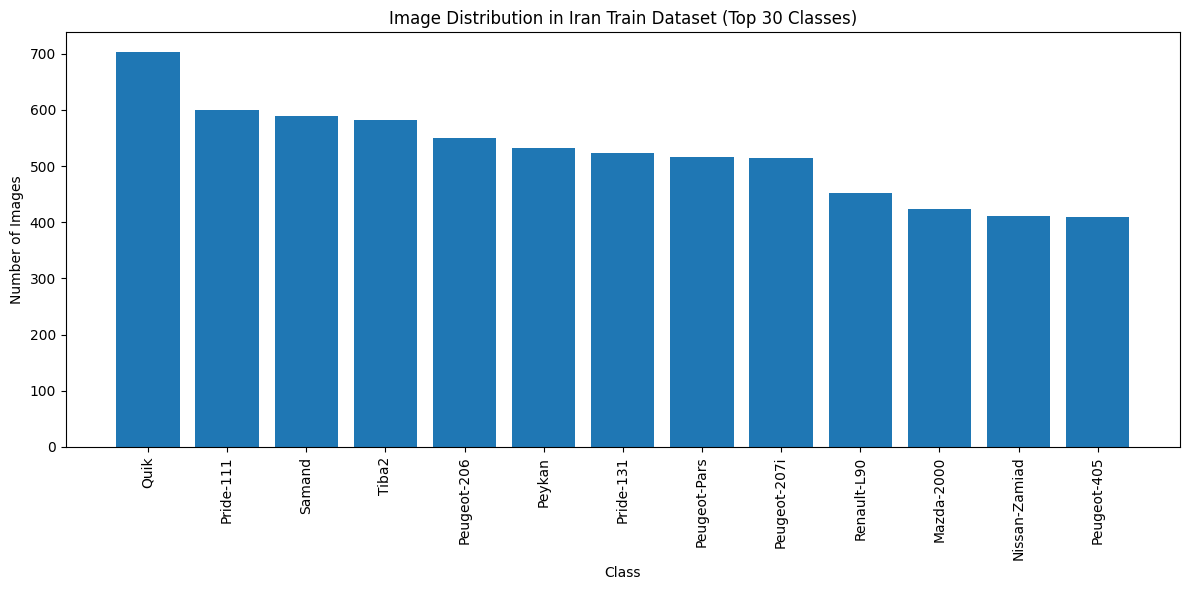


=== Analyzing Iran Test Dataset ===


Analyzing Iran Test classes: 100%|██████████| 13/13 [00:04<00:00,  2.78it/s]


Total number of classes: 13
Total number of images: 1474
Average images per class: 113.38
Minimum images per class: 89
Maximum images per class: 152


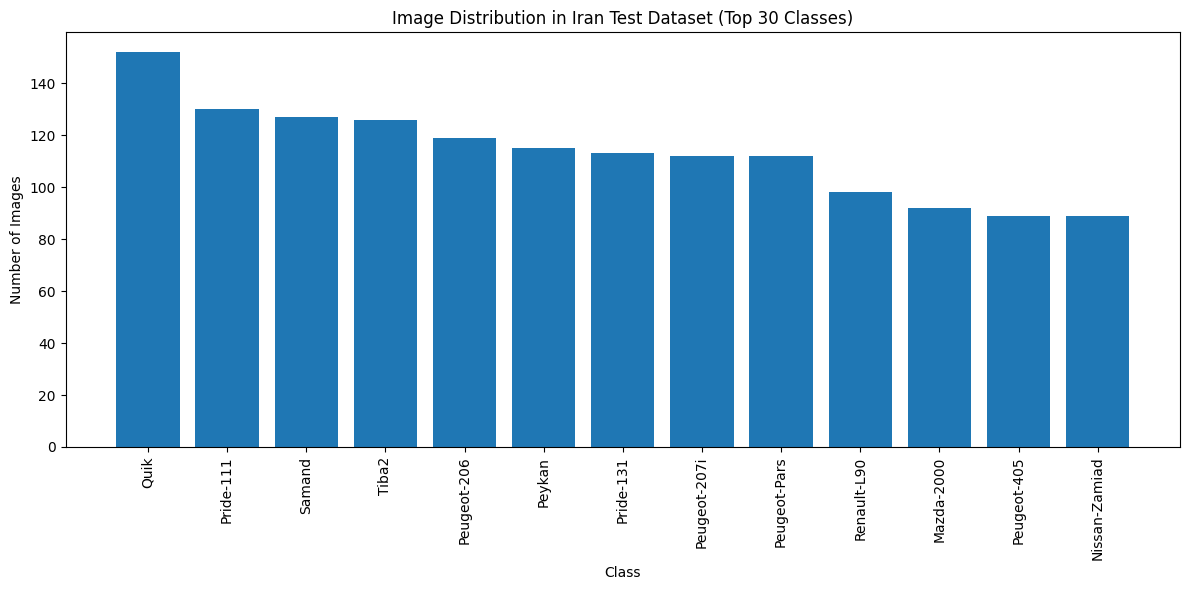


=== Analyzing Stanford Train Dataset ===


Analyzing Stanford Train classes: 100%|██████████| 196/196 [00:19<00:00, 10.13it/s]


Total number of classes: 196
Total number of images: 8144
Average images per class: 41.55
Minimum images per class: 24
Maximum images per class: 68


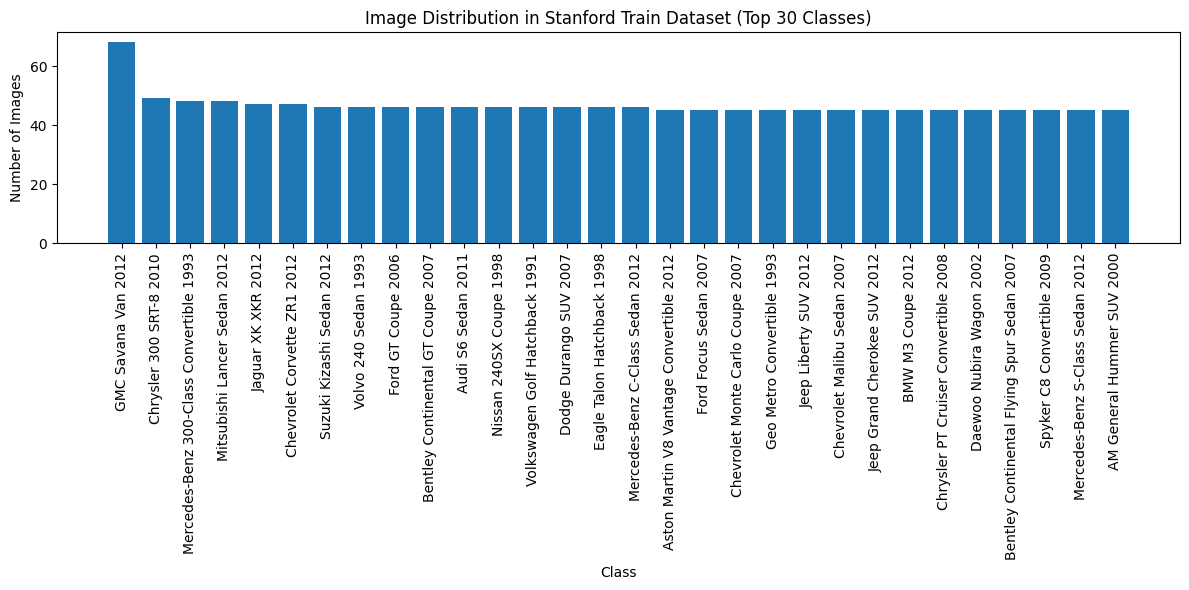


=== Analyzing Stanford Test Dataset ===


Analyzing Stanford Test classes: 100%|██████████| 196/196 [00:18<00:00, 10.80it/s]


Total number of classes: 196
Total number of images: 8041
Average images per class: 41.03
Minimum images per class: 24
Maximum images per class: 68


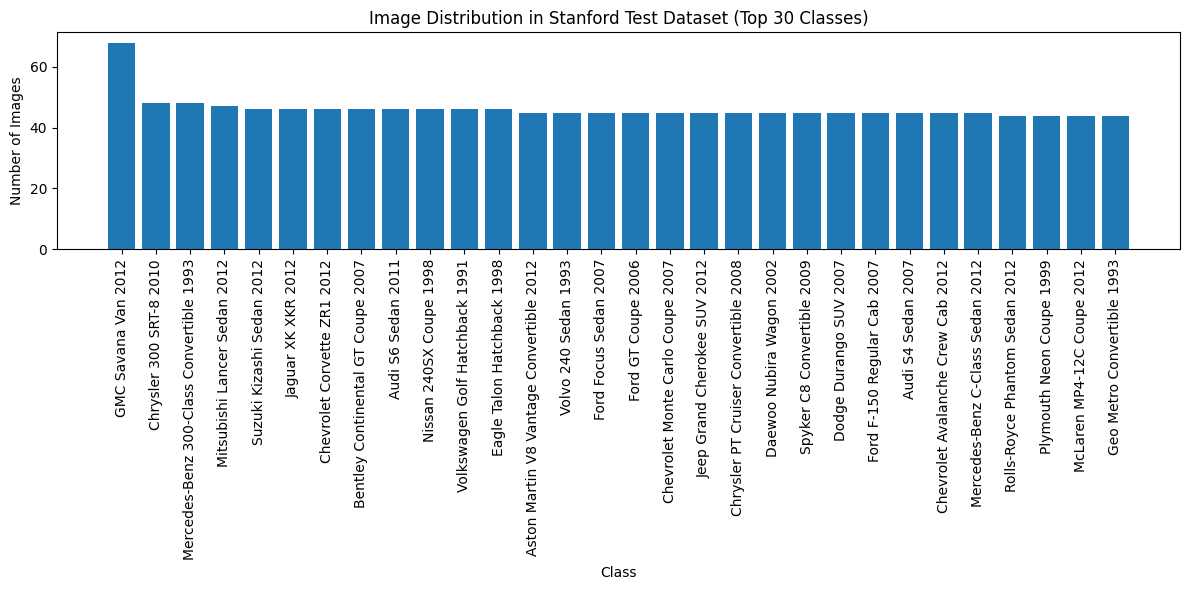


=== Combined Dataset Statistics ===
Total classes: 209
Total training images: 14953
Total testing images: 9515



In [ ]:
# Define data paths
data_paths = {
    'iran_train': '/kaggle/input/iran-used-cars-dataset/iran-used-cars-dataset/split/train',
    'iran_test': '/kaggle/input/iran-used-cars-dataset/iran-used-cars-dataset/split/test',
    'stanford_train': '/kaggle/input/stanford-car-dataset-by-classes-folder/car_data/car_data/train',
    'stanford_test': '/kaggle/input/stanford-car-dataset-by-classes-folder/car_data/car_data/test'
}

# Function to analyze dataset
def analyze_dataset(dataset_path, dataset_name):
    classes = os.listdir(dataset_path)
    class_counts = {}

    print(f"\n=== Analyzing {dataset_name} Dataset ===")

    for class_name in tqdm(classes, desc=f"Analyzing {dataset_name} classes"):
        class_path = os.path.join(dataset_path, class_name)
        if os.path.isdir(class_path):
            files = [f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f)) and
                     f.lower().endswith(('.png', '.jpg', '.jpeg'))]
            class_counts[class_name] = len(files)

    # Sort classes by count
    class_counts = {k: v for k, v in sorted(class_counts.items(), key=lambda item: item[1], reverse=True)}

    # Calculate statistics
    total_images = sum(class_counts.values())
    num_classes = len(class_counts)
    avg_images_per_class = total_images / num_classes if num_classes > 0 else 0
    min_images = min(class_counts.values()) if class_counts else 0
    max_images = max(class_counts.values()) if class_counts else 0

    print(f"Total number of classes: {num_classes}")
    print(f"Total number of images: {total_images}")
    print(f"Average images per class: {avg_images_per_class:.2f}")
    print(f"Minimum images per class: {min_images}")
    print(f"Maximum images per class: {max_images}")

    # Plot distribution
    plt.figure(figsize=(12, 6))
    classes_to_plot = list(class_counts.keys())[:30]  # Plot top 30 classes for visibility
    counts_to_plot = [class_counts[cls] for cls in classes_to_plot]

    plt.bar(range(len(classes_to_plot)), counts_to_plot)
    plt.xticks(range(len(classes_to_plot)), classes_to_plot, rotation=90)
    plt.xlabel('Class')
    plt.ylabel('Number of Images')
    plt.title(f'Image Distribution in {dataset_name} Dataset (Top 30 Classes)')
    plt.tight_layout()
    plt.show()

    return class_counts, total_images, num_classes

# Analyze each dataset
iran_train_counts, iran_train_total, iran_train_classes = analyze_dataset(data_paths['iran_train'], 'Iran Train')
iran_test_counts, iran_test_total, iran_test_classes = analyze_dataset(data_paths['iran_test'], 'Iran Test')
stanford_train_counts, stanford_train_total, stanford_train_classes = analyze_dataset(data_paths['stanford_train'], 'Stanford Train')
stanford_test_counts, stanford_test_total, stanford_test_classes = analyze_dataset(data_paths['stanford_test'], 'Stanford Test')

# Print totals for combined dataset
print("\n=== Combined Dataset Statistics ===")
print(f"Total classes: {iran_train_classes + stanford_train_classes}")
print(f"Total training images: {iran_train_total + stanford_train_total}")
print(f"Total testing images: {iran_test_total + stanford_test_total}")
print("=============================\n")


## Block 3: Custom Dataset and Data Augmentation

Dataset created with 14953 samples across 209 classes
Dataset created with 9515 samples across 209 classes
Class weights calculated for handling imbalance
Using weighted sampler for training data
Created train loader with 468 batches and test loader with 298 batches


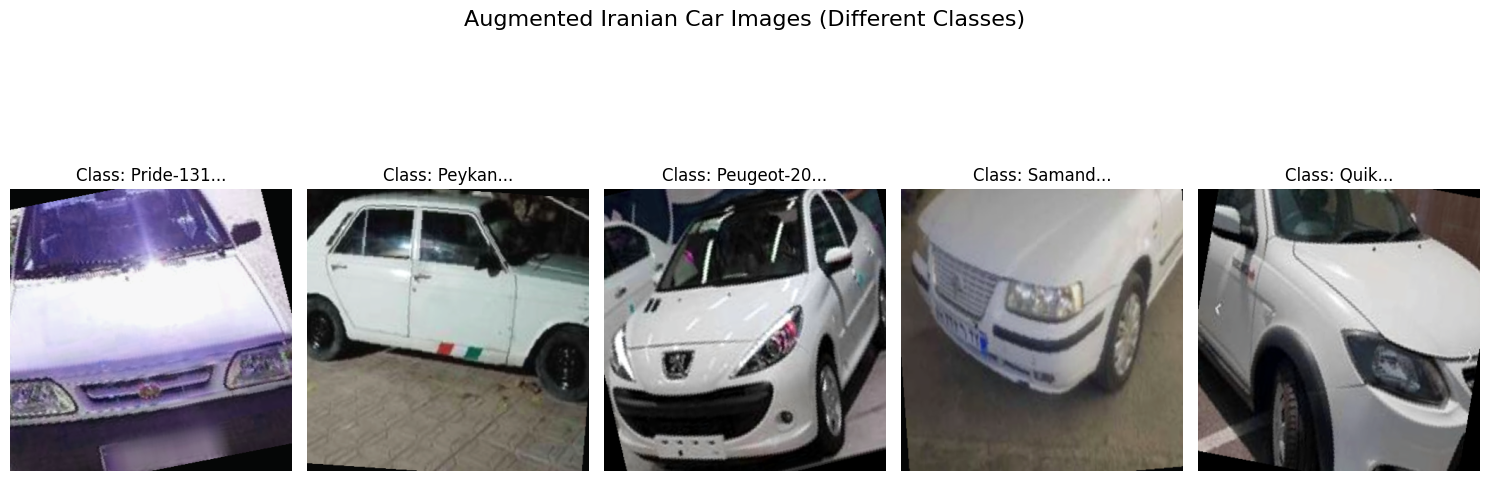

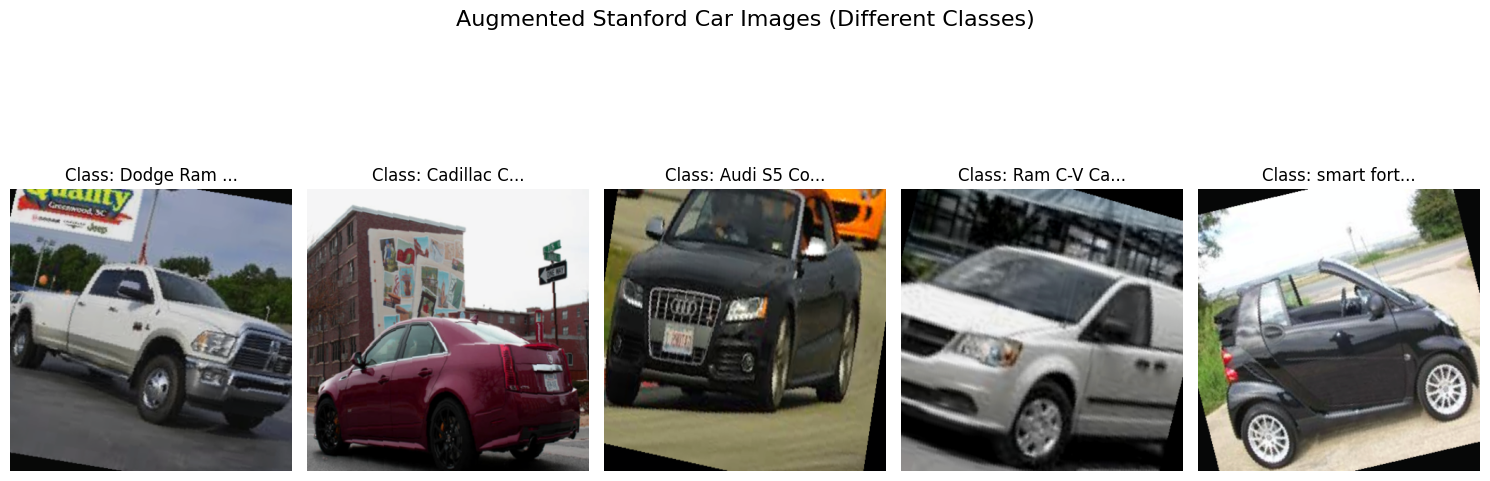

In [ ]:
class CarDataset(Dataset):
    def __init__(self, iran_path=None, stanford_path=None, transform=None):
        self.transform = transform
        self.samples = []
        self.class_to_idx = {}
        self.classes = []

        # Process datasets
        if iran_path:
            self._process_directory(iran_path, "Iran")
        if stanford_path:
            self._process_directory(stanford_path, "Stanford")

        print(f"Dataset created with {len(self.samples)} samples across {len(self.classes)} classes")

    def _process_directory(self, root_dir, dataset_type):
        class_dirs = [d for d in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, d))]

        for class_dir in class_dirs:
            class_path = os.path.join(root_dir, class_dir)
            if class_dir not in self.class_to_idx:
                self.class_to_idx[class_dir] = len(self.classes)
                self.classes.append(class_dir)

            class_idx = self.class_to_idx[class_dir]

            for img_name in os.listdir(class_path):
                img_path = os.path.join(class_path, img_name)
                if os.path.isfile(img_path) and img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                    self.samples.append((img_path, class_idx, dataset_type))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, class_idx, dataset_type = self.samples[idx]

        try:
            img = Image.open(img_path).convert('RGB')

            if self.transform:
                img = self.transform(img)

            return img, class_idx, dataset_type
        except Exception as e:
            print(f"Error loading image {img_path}: {e}")
            # Return a placeholder image and the same class
            placeholder = torch.zeros((3, params['image_size'], params['image_size']))
            return placeholder, class_idx, dataset_type

# Define data transformations
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((params['image_size'], params['image_size'])),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(degrees=15),
        transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
        transforms.RandomResizedCrop(params['image_size'], scale=(0.8, 1.0)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize((params['image_size'], params['image_size'])),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# Create datasets
train_dataset = CarDataset(
    iran_path=data_paths['iran_train'],
    stanford_path=data_paths['stanford_train'],
    transform=data_transforms['train']
)

test_dataset = CarDataset(
    iran_path=data_paths['iran_test'],
    stanford_path=data_paths['stanford_test'],
    transform=data_transforms['test']
)

# Calculate class weights for handling class imbalance
def calculate_class_weights(dataset):
    class_counts = [0] * len(dataset.classes)
    for _, class_idx, _ in dataset.samples:
        class_counts[class_idx] += 1

    # Calculate weights as inverse of frequency
    class_weights = [len(dataset) / (len(dataset.classes) * count) if count > 0 else 1.0 for count in class_counts]
    return torch.FloatTensor(class_weights)

class_weights = calculate_class_weights(train_dataset)
print("Class weights calculated for handling imbalance")

# Create weighted sampler for training data
def create_weighted_sampler(dataset):
    sample_weights = [0] * len(dataset)
    for idx, (_, class_idx, _) in enumerate(dataset.samples):
        sample_weights[idx] = class_weights[class_idx]

    return WeightedRandomSampler(sample_weights, len(sample_weights))

# Create data loaders
if params['use_weighted_sampler']:
    print("Using weighted sampler for training data")
    sampler = create_weighted_sampler(train_dataset)
    train_loader = DataLoader(train_dataset, batch_size=params['batch_size'],
                             sampler=sampler, num_workers=params['num_workers'], pin_memory=True)
else:
    print("Using random sampling for training data")
    train_loader = DataLoader(train_dataset, batch_size=params['batch_size'],
                             shuffle=True, num_workers=params['num_workers'], pin_memory=True)

test_loader = DataLoader(test_dataset, batch_size=params['batch_size'],
                         shuffle=False, num_workers=params['num_workers'], pin_memory=True)

print(f"Created train loader with {len(train_loader)} batches and test loader with {len(test_loader)} batches")

# Visualize augmented images
def show_augmented_images(dataset, num_iran=5, num_stanford=5):
    """
    Shows augmented images from Iran and Stanford car datasets.
    For each dataset, selects images from different classes.

    Args:
        dataset: The dataset containing the images
        num_iran: Number of Iranian car images to display
        num_stanford: Number of Stanford car images to display
    """
    # Dictionaries to track classes we've seen
    iran_classes_seen = {}
    stanford_classes_seen = {}

    # Lists to store indices of selected images
    iran_indices = []
    stanford_indices = []

    # Iterate through dataset to find diverse classes
    for i, (_, class_idx, dataset_type) in enumerate(dataset.samples):
        class_name = dataset.classes[class_idx]

        if dataset_type == "Iran" and len(iran_indices) < num_iran:
            # Only add if we haven't seen this class yet
            if class_name not in iran_classes_seen:
                iran_classes_seen[class_name] = True
                iran_indices.append(i)
        elif dataset_type == "Stanford" and len(stanford_indices) < num_stanford:
            # Only add if we haven't seen this class yet
            if class_name not in stanford_classes_seen:
                stanford_classes_seen[class_name] = True
                stanford_indices.append(i)

        # Break if we have enough images from different classes
        if len(iran_indices) >= num_iran and len(stanford_indices) >= num_stanford:
            break

    # If we couldn't find enough different classes, fill with additional images
    if len(iran_indices) < num_iran:
        for i, (_, class_idx, dataset_type) in enumerate(dataset.samples):
            if dataset_type == "Iran" and i not in iran_indices:
                iran_indices.append(i)
                if len(iran_indices) >= num_iran:
                    break

    if len(stanford_indices) < num_stanford:
        for i, (_, class_idx, dataset_type) in enumerate(dataset.samples):
            if dataset_type == "Stanford" and i not in stanford_indices:
                stanford_indices.append(i)
                if len(stanford_indices) >= num_stanford:
                    break

    # Show Iran cars
    plt.figure(figsize=(15, 6))
    plt.suptitle("Augmented Iranian Car Images (Different Classes)", fontsize=16)

    for i, idx in enumerate(iran_indices):
        img, class_idx, _ = dataset[idx]
        ax = plt.subplot(1, num_iran, i + 1)
        img = img.permute(1, 2, 0).numpy()
        img = np.clip(img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406]), 0, 1)
        plt.imshow(img)
        plt.title(f"Class: {dataset.classes[class_idx][:10]}...")
        plt.axis("off")

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

    # Show Stanford cars
    plt.figure(figsize=(15, 6))
    plt.suptitle("Augmented Stanford Car Images (Different Classes)", fontsize=16)

    for i, idx in enumerate(stanford_indices):
        img, class_idx, _ = dataset[idx]
        ax = plt.subplot(1, num_stanford, i + 1)
        img = img.permute(1, 2, 0).numpy()
        img = np.clip(img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406]), 0, 1)
        plt.imshow(img)
        plt.title(f"Class: {dataset.classes[class_idx][:10]}...")
        plt.axis("off")

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

# Call the function to display images
show_augmented_images(train_dataset)

## Block 4: CBAM Implementation

In [ ]:
# Convolutional Block Attention Module (CBAM)
class ChannelAttention(nn.Module):
    def __init__(self, in_channels, reduction_ratio=16):
        super(ChannelAttention, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)

        self.fc = nn.Sequential(
            nn.Conv2d(in_channels, in_channels // reduction_ratio, kernel_size=1, bias=False),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels // reduction_ratio, in_channels, kernel_size=1, bias=False)
        )

    def forward(self, x):
        avg_out = self.fc(self.avg_pool(x))
        max_out = self.fc(self.max_pool(x))
        out = avg_out + max_out
        return torch.sigmoid(out)

class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super(SpatialAttention, self).__init__()
        padding = kernel_size // 2
        self.conv = nn.Conv2d(2, 1, kernel_size=kernel_size, padding=padding, bias=False)

    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        out = torch.cat([avg_out, max_out], dim=1)
        out = self.conv(out)
        return torch.sigmoid(out)

class CBAM(nn.Module):
    def __init__(self, in_channels, reduction_ratio=16, kernel_size=7):
        super(CBAM, self).__init__()
        self.channel_attention = ChannelAttention(in_channels, reduction_ratio)
        self.spatial_attention = SpatialAttention(kernel_size)

    def forward(self, x):
        x = x * self.channel_attention(x)
        x = x * self.spatial_attention(x)
        return x

## Block 5: ResNet-18 with CBAM Architecture

In [ ]:
class ResNet18WithCBAM(nn.Module):
    def __init__(self, num_classes, pretrained=True):
        super(ResNet18WithCBAM, self).__init__()
        # Load pretrained ResNet-18 backbone
        model = models.resnet18(pretrained=pretrained)

        # Stem: initial conv, batchnorm, ReLU, and max-pool
        self.conv1   = model.conv1       # 7x7 convolution
        self.bn1     = model.bn1         # Batch normalization
        self.relu    = model.relu        # ReLU activation
        self.maxpool = model.maxpool     # 3x3 max pooling

        # Residual layers (Conv2_x to Conv5_x)
        self.layer1 = model.layer1       # Output channels: 64
        self.layer2 = model.layer2       # Output channels: 128
        self.layer3 = model.layer3       # Output channels: 256
        self.layer4 = model.layer4       # Output channels: 512

        # CBAM modules inserted at mid-level features
        self.cbam_after_l2 = CBAM(in_channels=128)  # After layer2
        self.cbam_after_l3 = CBAM(in_channels=256)  # After layer3

        # Classification head: global avg pool and FC layer
        self.avgpool = model.avgpool              # Adaptive average pooling
        self.fc      = nn.Linear(512, num_classes)  # Final fully connected layer

    def forward(self, x):
        # ---- Stem ----
        x = self.conv1(x)     # [B, 64, H/2, W/2]
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)   # [B, 64, H/4, W/4]

        # ---- Residual Stage 1 ----
        x = self.layer1(x)    # [B, 64, H/4, W/4]

        # ---- Residual Stage 2 + CBAM ----
        x = self.layer2(x)    # [B, 128, H/8, W/8]
        x = self.cbam_after_l2(x)  # Apply CBAM on layer2 output

        # ---- Residual Stage 3 + CBAM ----
        x = self.layer3(x)    # [B, 256, H/16, W/16]
        x = self.cbam_after_l3(x)  # Apply CBAM on layer3 output

        # ---- Residual Stage 4 ----
        x = self.layer4(x)    # [B, 512, H/32, W/32]

        # ---- Classification Head ----
        x = self.avgpool(x)            # [B, 512, 1, 1]
        x = torch.flatten(x, 1)        # [B, 512]
        x = self.fc(x)                 # [B, num_classes]
        return x


## Block 6: Model Setup, Loss Function, and Optimizer

In [ ]:
# Initialize model

warnings.filterwarnings("ignore", category=UserWarning, module='torchvision.models._utils')

model = ResNet18WithCBAM(num_classes=len(train_dataset.classes), pretrained=params['pretrained'])

# Print model summary
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print("\n=== Model Summary ===")
print(f"Model type: ResNet-18 with CBAM")
print(f"Number of classes: {len(train_dataset.classes)}")
print(f"Trainable parameters: {count_parameters(model):,}")
print(f"Using pretrained weights: {params['pretrained']}")
print(f"CBAM modules: 2 (after layer2 and layer3)")
print("=====================\n")

# Multi-GPU support
if torch.cuda.device_count() > 1:
    print(f"Using {torch.cuda.device_count()} GPUs for training")
    model = nn.DataParallel(model)

model = model.to(device)

# Define loss function
if params['use_class_weights']:
    criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))
    print("Using weighted cross entropy loss to handle class imbalance")
else:
    criterion = nn.CrossEntropyLoss()
    print("Using standard cross entropy loss")

# Define optimizer
optimizer = optim.Adam(
    model.parameters(),
    lr=params['learning_rate'],
    weight_decay=params['weight_decay']
)

# Learning rate scheduler
scheduler = optim.lr_scheduler.StepLR(
    optimizer,
    step_size=params['lr_scheduler_step'],
    gamma=params['lr_scheduler_gamma']
)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 185MB/s]



=== Model Summary ===
Model type: ResNet-18 with CBAM
Number of classes: 209
Trainable parameters: 11,294,165
Using pretrained weights: True
CBAM modules: 2 (after layer2 and layer3)

Using 2 GPUs for training
Using weighted cross entropy loss to handle class imbalance


## Block 7: Training and Evaluation Functions

In [ ]:
def train_one_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_targets = []

    with tqdm(train_loader, desc='Training') as pbar:
        for batch_idx, (inputs, targets, _) in enumerate(pbar):
            inputs, targets = inputs.to(device), targets.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            # Statistics
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

            # Store for metrics calculation
            all_preds.extend(predicted.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())

            # Update progress bar
            pbar.set_postfix({
                'loss': running_loss / (batch_idx + 1),
                'acc': 100. * correct / total
            })

    # Calculate metrics
    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100. * correct / total
    epoch_precision = precision_score(all_targets, all_preds, average='weighted')
    epoch_recall = recall_score(all_targets, all_preds, average='weighted')
    epoch_f1 = f1_score(all_targets, all_preds, average='weighted')

    metrics = {
        'loss': epoch_loss,
        'accuracy': epoch_acc,
        'precision': epoch_precision * 100,
        'recall': epoch_recall * 100,
        'f1_score': epoch_f1 * 100
    }

    return metrics

def evaluate(model, test_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_targets = []
    all_outputs = []
    all_dataset_types = []

    with torch.no_grad():
        with tqdm(test_loader, desc='Evaluating') as pbar:
            for batch_idx, (inputs, targets, dataset_types) in enumerate(pbar):
                inputs, targets = inputs.to(device), targets.to(device)

                # Forward pass
                outputs = model(inputs)
                loss = criterion(outputs, targets)

                # Statistics
                running_loss += loss.item()
                _, predicted = outputs.max(1)
                total += targets.size(0)
                correct += predicted.eq(targets).sum().item()

                # Store for metrics calculation
                all_preds.extend(predicted.cpu().numpy())
                all_targets.extend(targets.cpu().numpy())
                all_outputs.extend(F.softmax(outputs, dim=1).cpu().numpy())
                all_dataset_types.extend(dataset_types)

                # Update progress bar
                pbar.set_postfix({
                    'loss': running_loss / (batch_idx + 1),
                    'acc': 100. * correct / total
                })

    # Calculate metrics
    epoch_loss = running_loss / len(test_loader)
    epoch_acc = 100. * correct / total
    epoch_precision = precision_score(all_targets, all_preds, average='weighted')
    epoch_recall = recall_score(all_targets, all_preds, average='weighted')
    epoch_f1 = f1_score(all_targets, all_preds, average='weighted')

    metrics = {
        'loss': epoch_loss,
        'accuracy': epoch_acc,
        'precision': epoch_precision * 100,
        'recall': epoch_recall * 100,
        'f1_score': epoch_f1 * 100,
        'predictions': all_preds,
        'targets': all_targets,
        'outputs': all_outputs,
        'dataset_types': all_dataset_types
    }

    return metrics


## Block 8: Training Loop with Early Stopping

In [ ]:
# Training history
history = {
    'train_loss': [],
    'train_acc': [],
    'train_precision': [],
    'train_recall': [],
    'train_f1': [],
    'val_loss': [],
    'val_acc': [],
    'val_precision': [],
    'val_recall': [],
    'val_f1': []
}

# Early stopping variables
best_val_f1 = 0.0
patience_counter = 0
best_model_state = None

warnings.filterwarnings("ignore", category=UndefinedMetricWarning)

# Training loop
print("\n=== Starting Training ===")
for epoch in range(params['epochs']):
    epoch_start_time = time.time()
    print(f"\nEpoch {epoch+1}/{params['epochs']}")



    # Train
    train_metrics = train_one_epoch(model, train_loader, criterion, optimizer, device)

    # Evaluate
    val_metrics = evaluate(model, test_loader, criterion, device)

    # Update learning rate
    scheduler.step()

    # Record metrics
    history['train_loss'].append(train_metrics['loss'])
    history['train_acc'].append(train_metrics['accuracy'])
    history['train_precision'].append(train_metrics['precision'])
    history['train_recall'].append(train_metrics['recall'])
    history['train_f1'].append(train_metrics['f1_score'])

    history['val_loss'].append(val_metrics['loss'])
    history['val_acc'].append(val_metrics['accuracy'])
    history['val_precision'].append(val_metrics['precision'])
    history['val_recall'].append(val_metrics['recall'])
    history['val_f1'].append(val_metrics['f1_score'])


    # Calculate epoch time
    epoch_time = time.time() - epoch_start_time

    # Print epoch results
    print(f"Epoch {epoch+1}/{params['epochs']} completed in {epoch_time:.2f}s")
    print(f"Train Loss: {train_metrics['loss']:.4f}, Train Acc: {train_metrics['accuracy']:.2f}%")
    print(f"Train Precision: {train_metrics['precision']:.2f}%, Train Recall: {train_metrics['recall']:.2f}%, Train F1: {train_metrics['f1_score']:.2f}%")
    print(f"Val Loss: {val_metrics['loss']:.4f}, Val Acc: {val_metrics['accuracy']:.2f}%")
    print(f"Val Precision: {val_metrics['precision']:.2f}%, Val Recall: {val_metrics['recall']:.2f}%, Val F1: {val_metrics['f1_score']:.2f}%")

    # Early stopping
    if val_metrics['f1_score'] > best_val_f1:
        best_val_f1 = val_metrics['f1_score']
        patience_counter = 0
        print(f"New best model with F1 Score: {best_val_f1:.2f}%")

        # Save best model state
        if torch.cuda.device_count() > 1:
            best_model_state = model.module.state_dict()
        else:
            best_model_state = model.state_dict()
    else:
        patience_counter += 1
        print(f"No improvement in F1 Score for {patience_counter} epochs. Best: {best_val_f1:.2f}%")

        if patience_counter >= params['early_stopping_patience']:
            print(f"Early stopping triggered after {epoch+1} epochs")
            break

# Load best model
if best_model_state is not None:
    if torch.cuda.device_count() > 1:
        model.module.load_state_dict(best_model_state)
    else:
        model.load_state_dict(best_model_state)
    print(f"Loaded best model with F1 Score: {best_val_f1:.2f}%")

print("=== Training Complete ===\n")



=== Starting Training ===

Epoch 1/40


Evaluating: 100%|██████████| 298/298 [01:03<00:00,  4.72it/s, loss=5.64, acc=0.736]


Epoch 1/40 completed in 282.28s
Train Loss: 5.3483, Train Acc: 0.78%
Train Precision: 0.40%, Train Recall: 0.78%, Train F1: 0.44%
Val Loss: 5.6368, Val Acc: 0.74%
Val Precision: 0.02%, Val Recall: 0.74%, Val F1: 0.03%
New best model with F1 Score: 0.03%

Epoch 2/40


Evaluating: 100%|██████████| 298/298 [00:55<00:00,  5.36it/s, loss=5.52, acc=0.851]


Epoch 2/40 completed in 273.44s
Train Loss: 5.1710, Train Acc: 1.18%
Train Precision: 0.52%, Train Recall: 1.18%, Train F1: 0.54%
Val Loss: 5.5159, Val Acc: 0.85%
Val Precision: 0.04%, Val Recall: 0.85%, Val F1: 0.08%
New best model with F1 Score: 0.08%

Epoch 3/40


Evaluating: 100%|██████████| 298/298 [00:54<00:00,  5.48it/s, loss=5.34, acc=1.8]  


Epoch 3/40 completed in 272.70s
Train Loss: 5.0141, Train Acc: 1.75%
Train Precision: 0.86%, Train Recall: 1.75%, Train F1: 0.98%
Val Loss: 5.3373, Val Acc: 1.80%
Val Precision: 0.47%, Val Recall: 1.80%, Val F1: 0.45%
New best model with F1 Score: 0.45%

Epoch 4/40


Evaluating: 100%|██████████| 298/298 [00:58<00:00,  5.08it/s, loss=5.11, acc=2.92]


Epoch 4/40 completed in 285.02s
Train Loss: 4.6774, Train Acc: 3.28%
Train Precision: 2.15%, Train Recall: 3.28%, Train F1: 2.06%
Val Loss: 5.1055, Val Acc: 2.92%
Val Precision: 1.51%, Val Recall: 2.92%, Val F1: 1.06%
New best model with F1 Score: 1.06%

Epoch 5/40


Evaluating: 100%|██████████| 298/298 [01:05<00:00,  4.57it/s, loss=4.67, acc=6.42]


Epoch 5/40 completed in 310.30s
Train Loss: 4.1639, Train Acc: 7.08%
Train Precision: 5.85%, Train Recall: 7.08%, Train F1: 5.70%
Val Loss: 4.6690, Val Acc: 6.42%
Val Precision: 8.01%, Val Recall: 6.42%, Val F1: 4.25%
New best model with F1 Score: 4.25%

Epoch 6/40


Evaluating: 100%|██████████| 298/298 [01:07<00:00,  4.44it/s, loss=3.67, acc=17.9]


Epoch 6/40 completed in 317.88s
Train Loss: 3.4567, Train Acc: 15.86%
Train Precision: 15.01%, Train Recall: 15.86%, Train F1: 13.93%
Val Loss: 3.6684, Val Acc: 17.94%
Val Precision: 22.86%, Val Recall: 17.94%, Val F1: 14.50%
New best model with F1 Score: 14.50%

Epoch 7/40


Evaluating: 100%|██████████| 298/298 [01:01<00:00,  4.87it/s, loss=2.92, acc=27.1]


Epoch 7/40 completed in 286.81s
Train Loss: 2.7077, Train Acc: 28.36%
Train Precision: 27.85%, Train Recall: 28.36%, Train F1: 26.67%
Val Loss: 2.9234, Val Acc: 27.14%
Val Precision: 40.93%, Val Recall: 27.14%, Val F1: 24.45%
New best model with F1 Score: 24.45%

Epoch 8/40


Evaluating: 100%|██████████| 298/298 [00:55<00:00,  5.36it/s, loss=2.61, acc=34.4]


Epoch 8/40 completed in 278.59s
Train Loss: 1.9953, Train Acc: 43.92%
Train Precision: 44.03%, Train Recall: 43.92%, Train F1: 42.66%
Val Loss: 2.6114, Val Acc: 34.43%
Val Precision: 48.86%, Val Recall: 34.43%, Val F1: 32.61%
New best model with F1 Score: 32.61%

Epoch 9/40


Evaluating: 100%|██████████| 298/298 [00:59<00:00,  5.02it/s, loss=1.95, acc=48.5]


Epoch 9/40 completed in 274.11s
Train Loss: 1.4420, Train Acc: 57.03%
Train Precision: 56.87%, Train Recall: 57.03%, Train F1: 55.97%
Val Loss: 1.9539, Val Acc: 48.54%
Val Precision: 60.62%, Val Recall: 48.54%, Val F1: 47.63%
New best model with F1 Score: 47.63%

Epoch 10/40


Evaluating: 100%|██████████| 298/298 [00:57<00:00,  5.17it/s, loss=1.86, acc=51.4]


Epoch 10/40 completed in 279.01s
Train Loss: 1.0597, Train Acc: 66.94%
Train Precision: 66.82%, Train Recall: 66.94%, Train F1: 66.09%
Val Loss: 1.8572, Val Acc: 51.36%
Val Precision: 64.37%, Val Recall: 51.36%, Val F1: 52.02%
New best model with F1 Score: 52.02%

Epoch 11/40


Evaluating: 100%|██████████| 298/298 [00:57<00:00,  5.14it/s, loss=1.29, acc=65.1]


Epoch 11/40 completed in 273.17s
Train Loss: 0.6612, Train Acc: 79.01%
Train Precision: 79.00%, Train Recall: 79.01%, Train F1: 78.48%
Val Loss: 1.2874, Val Acc: 65.14%
Val Precision: 70.13%, Val Recall: 65.14%, Val F1: 64.63%
New best model with F1 Score: 64.63%

Epoch 12/40


Evaluating: 100%|██████████| 298/298 [00:55<00:00,  5.33it/s, loss=1.23, acc=66.9]


Epoch 12/40 completed in 276.00s
Train Loss: 0.4932, Train Acc: 83.77%
Train Precision: 83.65%, Train Recall: 83.77%, Train F1: 83.28%
Val Loss: 1.2292, Val Acc: 66.92%
Val Precision: 71.91%, Val Recall: 66.92%, Val F1: 66.47%
New best model with F1 Score: 66.47%

Epoch 13/40


Evaluating: 100%|██████████| 298/298 [00:55<00:00,  5.33it/s, loss=1.13, acc=70.1]


Epoch 13/40 completed in 277.87s
Train Loss: 0.4190, Train Acc: 85.82%
Train Precision: 85.68%, Train Recall: 85.82%, Train F1: 85.38%
Val Loss: 1.1287, Val Acc: 70.12%
Val Precision: 73.60%, Val Recall: 70.12%, Val F1: 69.84%
New best model with F1 Score: 69.84%

Epoch 14/40


Evaluating: 100%|██████████| 298/298 [00:54<00:00,  5.49it/s, loss=1.12, acc=70]  


Epoch 14/40 completed in 268.59s
Train Loss: 0.3295, Train Acc: 88.21%
Train Precision: 88.06%, Train Recall: 88.21%, Train F1: 87.81%
Val Loss: 1.1189, Val Acc: 69.95%
Val Precision: 74.32%, Val Recall: 69.95%, Val F1: 69.99%
New best model with F1 Score: 69.99%

Epoch 15/40


Evaluating: 100%|██████████| 298/298 [00:54<00:00,  5.48it/s, loss=1.13, acc=69.9]


Epoch 15/40 completed in 258.14s
Train Loss: 0.2624, Train Acc: 90.53%
Train Precision: 90.31%, Train Recall: 90.53%, Train F1: 90.23%
Val Loss: 1.1335, Val Acc: 69.86%
Val Precision: 74.30%, Val Recall: 69.86%, Val F1: 69.96%
No improvement in F1 Score for 1 epochs. Best: 69.99%

Epoch 16/40


Evaluating: 100%|██████████| 298/298 [00:53<00:00,  5.56it/s, loss=1.02, acc=72.9]


Epoch 16/40 completed in 254.83s
Train Loss: 0.2421, Train Acc: 91.15%
Train Precision: 91.02%, Train Recall: 91.15%, Train F1: 90.91%
Val Loss: 1.0226, Val Acc: 72.94%
Val Precision: 76.48%, Val Recall: 72.94%, Val F1: 72.87%
New best model with F1 Score: 72.87%

Epoch 17/40


Evaluating: 100%|██████████| 298/298 [00:56<00:00,  5.32it/s, loss=1.05, acc=73.2]


Epoch 17/40 completed in 258.84s
Train Loss: 0.2024, Train Acc: 92.01%
Train Precision: 91.80%, Train Recall: 92.01%, Train F1: 91.76%
Val Loss: 1.0456, Val Acc: 73.19%
Val Precision: 76.27%, Val Recall: 73.19%, Val F1: 73.27%
New best model with F1 Score: 73.27%

Epoch 18/40


Evaluating: 100%|██████████| 298/298 [00:54<00:00,  5.44it/s, loss=0.981, acc=74.7]


Epoch 18/40 completed in 264.89s
Train Loss: 0.1773, Train Acc: 92.98%
Train Precision: 92.81%, Train Recall: 92.98%, Train F1: 92.77%
Val Loss: 0.9811, Val Acc: 74.75%
Val Precision: 77.17%, Val Recall: 74.75%, Val F1: 74.81%
New best model with F1 Score: 74.81%

Epoch 19/40


Evaluating: 100%|██████████| 298/298 [00:54<00:00,  5.44it/s, loss=1.03, acc=73.7]


Epoch 19/40 completed in 265.12s
Train Loss: 0.1719, Train Acc: 93.03%
Train Precision: 92.89%, Train Recall: 93.03%, Train F1: 92.81%
Val Loss: 1.0252, Val Acc: 73.72%
Val Precision: 76.58%, Val Recall: 73.72%, Val F1: 73.69%
No improvement in F1 Score for 1 epochs. Best: 74.81%

Epoch 20/40


Evaluating: 100%|██████████| 298/298 [00:55<00:00,  5.40it/s, loss=1.1, acc=72.3] 


Epoch 20/40 completed in 266.51s
Train Loss: 0.1641, Train Acc: 93.59%
Train Precision: 93.45%, Train Recall: 93.59%, Train F1: 93.40%
Val Loss: 1.1025, Val Acc: 72.25%
Val Precision: 78.81%, Val Recall: 72.25%, Val F1: 73.21%
No improvement in F1 Score for 2 epochs. Best: 74.81%

Epoch 21/40


Evaluating: 100%|██████████| 298/298 [00:55<00:00,  5.37it/s, loss=0.844, acc=79]  


Epoch 21/40 completed in 264.61s
Train Loss: 0.0881, Train Acc: 95.87%
Train Precision: 95.78%, Train Recall: 95.87%, Train F1: 95.74%
Val Loss: 0.8441, Val Acc: 79.03%
Val Precision: 80.20%, Val Recall: 79.03%, Val F1: 79.03%
New best model with F1 Score: 79.03%

Epoch 22/40


Evaluating: 100%|██████████| 298/298 [00:54<00:00,  5.51it/s, loss=0.848, acc=79]  


Epoch 22/40 completed in 263.68s
Train Loss: 0.0713, Train Acc: 96.60%
Train Precision: 96.51%, Train Recall: 96.60%, Train F1: 96.50%
Val Loss: 0.8477, Val Acc: 78.98%
Val Precision: 80.33%, Val Recall: 78.98%, Val F1: 78.99%
No improvement in F1 Score for 1 epochs. Best: 79.03%

Epoch 23/40


Evaluating: 100%|██████████| 298/298 [00:54<00:00,  5.43it/s, loss=0.826, acc=79.2]


Epoch 23/40 completed in 262.58s
Train Loss: 0.0668, Train Acc: 96.86%
Train Precision: 96.80%, Train Recall: 96.86%, Train F1: 96.77%
Val Loss: 0.8263, Val Acc: 79.17%
Val Precision: 80.32%, Val Recall: 79.17%, Val F1: 79.18%
New best model with F1 Score: 79.18%

Epoch 24/40


Evaluating: 100%|██████████| 298/298 [00:54<00:00,  5.49it/s, loss=0.869, acc=79.1]


Epoch 24/40 completed in 268.48s
Train Loss: 0.0591, Train Acc: 97.05%
Train Precision: 97.01%, Train Recall: 97.05%, Train F1: 96.97%
Val Loss: 0.8690, Val Acc: 79.11%
Val Precision: 80.54%, Val Recall: 79.11%, Val F1: 79.11%
No improvement in F1 Score for 1 epochs. Best: 79.18%

Epoch 25/40


Evaluating: 100%|██████████| 298/298 [00:54<00:00,  5.48it/s, loss=0.832, acc=79.7]


Epoch 25/40 completed in 259.43s
Train Loss: 0.0528, Train Acc: 97.45%
Train Precision: 97.39%, Train Recall: 97.45%, Train F1: 97.38%
Val Loss: 0.8323, Val Acc: 79.74%
Val Precision: 81.08%, Val Recall: 79.74%, Val F1: 79.72%
New best model with F1 Score: 79.72%

Epoch 26/40


Evaluating: 100%|██████████| 298/298 [00:54<00:00,  5.51it/s, loss=0.881, acc=78.8]


Epoch 26/40 completed in 261.05s
Train Loss: 0.0573, Train Acc: 97.26%
Train Precision: 97.21%, Train Recall: 97.26%, Train F1: 97.19%
Val Loss: 0.8806, Val Acc: 78.81%
Val Precision: 80.73%, Val Recall: 78.81%, Val F1: 78.90%
No improvement in F1 Score for 1 epochs. Best: 79.72%

Epoch 27/40


Evaluating: 100%|██████████| 298/298 [00:54<00:00,  5.48it/s, loss=0.877, acc=78.6]


Epoch 27/40 completed in 263.39s
Train Loss: 0.0546, Train Acc: 97.26%
Train Precision: 97.20%, Train Recall: 97.26%, Train F1: 97.19%
Val Loss: 0.8774, Val Acc: 78.61%
Val Precision: 80.18%, Val Recall: 78.61%, Val F1: 78.64%
No improvement in F1 Score for 2 epochs. Best: 79.72%

Epoch 28/40


Evaluating: 100%|██████████| 298/298 [00:54<00:00,  5.43it/s, loss=0.867, acc=79.2]


Epoch 28/40 completed in 263.16s
Train Loss: 0.0497, Train Acc: 97.37%
Train Precision: 97.31%, Train Recall: 97.37%, Train F1: 97.29%
Val Loss: 0.8668, Val Acc: 79.19%
Val Precision: 80.89%, Val Recall: 79.19%, Val F1: 79.31%
No improvement in F1 Score for 3 epochs. Best: 79.72%

Epoch 29/40


Evaluating: 100%|██████████| 298/298 [00:54<00:00,  5.43it/s, loss=0.854, acc=79.8]


Epoch 29/40 completed in 261.97s
Train Loss: 0.0557, Train Acc: 97.16%
Train Precision: 97.09%, Train Recall: 97.16%, Train F1: 97.09%
Val Loss: 0.8539, Val Acc: 79.80%
Val Precision: 81.00%, Val Recall: 79.80%, Val F1: 79.78%
New best model with F1 Score: 79.78%

Epoch 30/40


Evaluating: 100%|██████████| 298/298 [00:54<00:00,  5.49it/s, loss=0.918, acc=78.5]


Epoch 30/40 completed in 260.76s
Train Loss: 0.0487, Train Acc: 97.69%
Train Precision: 97.65%, Train Recall: 97.69%, Train F1: 97.64%
Val Loss: 0.9183, Val Acc: 78.47%
Val Precision: 80.34%, Val Recall: 78.47%, Val F1: 78.55%
No improvement in F1 Score for 1 epochs. Best: 79.78%

Epoch 31/40


Evaluating: 100%|██████████| 298/298 [01:00<00:00,  4.94it/s, loss=0.802, acc=81.2]


Epoch 31/40 completed in 268.10s
Train Loss: 0.0342, Train Acc: 97.85%
Train Precision: 97.79%, Train Recall: 97.85%, Train F1: 97.79%
Val Loss: 0.8022, Val Acc: 81.21%
Val Precision: 82.27%, Val Recall: 81.21%, Val F1: 81.25%
New best model with F1 Score: 81.25%

Epoch 32/40


Evaluating: 100%|██████████| 298/298 [01:05<00:00,  4.57it/s, loss=0.768, acc=82]  


Epoch 32/40 completed in 299.80s
Train Loss: 0.0263, Train Acc: 98.21%
Train Precision: 98.18%, Train Recall: 98.21%, Train F1: 98.18%
Val Loss: 0.7683, Val Acc: 81.97%
Val Precision: 82.66%, Val Recall: 81.97%, Val F1: 81.97%
New best model with F1 Score: 81.97%

Epoch 33/40


Evaluating: 100%|██████████| 298/298 [01:07<00:00,  4.38it/s, loss=0.784, acc=81.4]


Epoch 33/40 completed in 315.48s
Train Loss: 0.0266, Train Acc: 98.35%
Train Precision: 98.33%, Train Recall: 98.35%, Train F1: 98.32%
Val Loss: 0.7839, Val Acc: 81.39%
Val Precision: 82.36%, Val Recall: 81.39%, Val F1: 81.38%
No improvement in F1 Score for 1 epochs. Best: 81.97%

Epoch 34/40


Evaluating: 100%|██████████| 298/298 [01:07<00:00,  4.42it/s, loss=0.798, acc=81]  


Epoch 34/40 completed in 324.98s
Train Loss: 0.0259, Train Acc: 98.42%
Train Precision: 98.38%, Train Recall: 98.42%, Train F1: 98.39%
Val Loss: 0.7985, Val Acc: 81.04%
Val Precision: 82.31%, Val Recall: 81.04%, Val F1: 81.12%
No improvement in F1 Score for 2 epochs. Best: 81.97%

Epoch 35/40


Evaluating: 100%|██████████| 298/298 [01:06<00:00,  4.47it/s, loss=0.779, acc=81.7]


Epoch 35/40 completed in 322.47s
Train Loss: 0.0288, Train Acc: 98.31%
Train Precision: 98.29%, Train Recall: 98.31%, Train F1: 98.29%
Val Loss: 0.7787, Val Acc: 81.73%
Val Precision: 82.47%, Val Recall: 81.73%, Val F1: 81.70%
No improvement in F1 Score for 3 epochs. Best: 81.97%

Epoch 36/40


Evaluating: 100%|██████████| 298/298 [00:56<00:00,  5.28it/s, loss=0.76, acc=81.8] 


Epoch 36/40 completed in 279.83s
Train Loss: 0.0245, Train Acc: 98.35%
Train Precision: 98.33%, Train Recall: 98.35%, Train F1: 98.32%
Val Loss: 0.7605, Val Acc: 81.82%
Val Precision: 82.77%, Val Recall: 81.82%, Val F1: 81.85%
No improvement in F1 Score for 4 epochs. Best: 81.97%

Epoch 37/40


Evaluating: 100%|██████████| 298/298 [00:55<00:00,  5.38it/s, loss=0.776, acc=81.7]

Epoch 37/40 completed in 266.35s
Train Loss: 0.0217, Train Acc: 98.64%
Train Precision: 98.62%, Train Recall: 98.64%, Train F1: 98.61%
Val Loss: 0.7763, Val Acc: 81.73%
Val Precision: 82.66%, Val Recall: 81.73%, Val F1: 81.75%
No improvement in F1 Score for 5 epochs. Best: 81.97%
Early stopping triggered after 37 epochs
Loaded best model with F1 Score: 81.97%
=== Training Complete ===



## Block 9: Visualize Training Progress

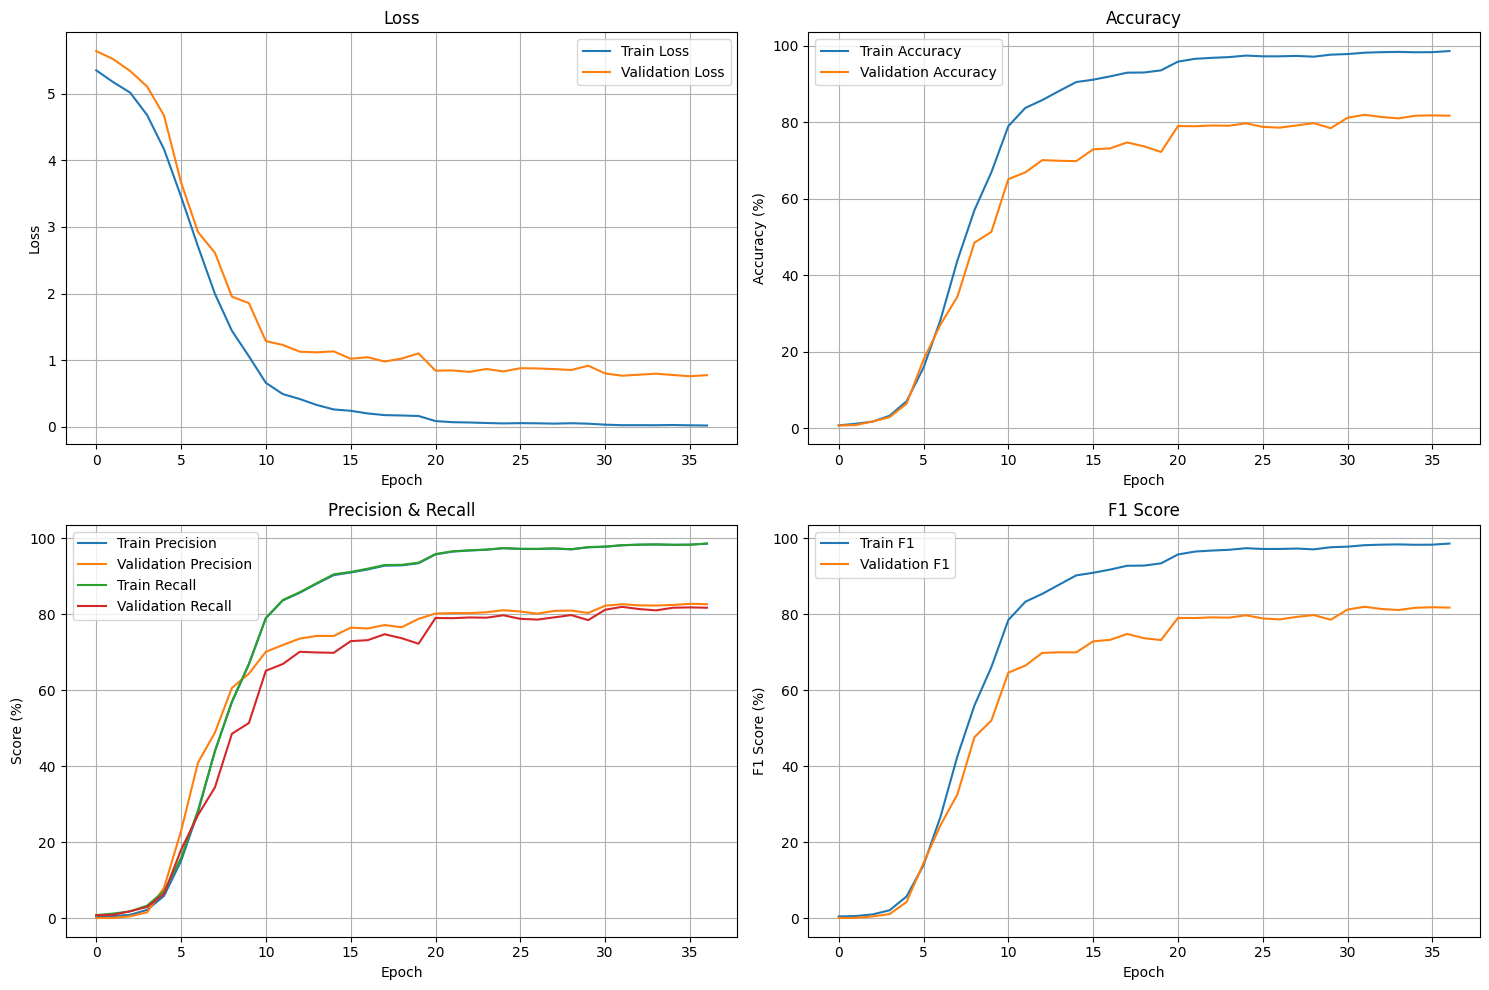

In [ ]:
# Plot training metrics
def plot_training_history(history):
    fig, axs = plt.subplots(2, 2, figsize=(15, 10))

    # Loss
    axs[0, 0].plot(history['train_loss'], label='Train Loss')
    axs[0, 0].plot(history['val_loss'], label='Validation Loss')
    axs[0, 0].set_title('Loss')
    axs[0, 0].set_xlabel('Epoch')
    axs[0, 0].set_ylabel('Loss')
    axs[0, 0].legend()
    axs[0, 0].grid(True)

    # Accuracy
    axs[0, 1].plot(history['train_acc'], label='Train Accuracy')
    axs[0, 1].plot(history['val_acc'], label='Validation Accuracy')
    axs[0, 1].set_title('Accuracy')
    axs[0, 1].set_xlabel('Epoch')
    axs[0, 1].set_ylabel('Accuracy (%)')
    axs[0, 1].legend()
    axs[0, 1].grid(True)

    # Precision & Recall
    axs[1, 0].plot(history['train_precision'], label='Train Precision')
    axs[1, 0].plot(history['val_precision'], label='Validation Precision')
    axs[1, 0].plot(history['train_recall'], label='Train Recall')
    axs[1, 0].plot(history['val_recall'], label='Validation Recall')
    axs[1, 0].set_title('Precision & Recall')
    axs[1, 0].set_xlabel('Epoch')
    axs[1, 0].set_ylabel('Score (%)')
    axs[1, 0].legend()
    axs[1, 0].grid(True)

    # F1 Score
    axs[1, 1].plot(history['train_f1'], label='Train F1')
    axs[1, 1].plot(history['val_f1'], label='Validation F1')
    axs[1, 1].set_title('F1 Score')
    axs[1, 1].set_xlabel('Epoch')
    axs[1, 1].set_ylabel('F1 Score (%)')
    axs[1, 1].legend()
    axs[1, 1].grid(True)

    plt.tight_layout()
    plt.show()

# Plot the training history
plot_training_history(history)

## Block 10: Final Evaluation and Confusion Matrix


=== Final Model Evaluation ===


Evaluating: 100%|██████████| 298/298 [00:53<00:00,  5.55it/s, loss=0.776, acc=81.7]


Final Test Loss: 0.7763
Final Test Accuracy: 81.73%
Final Test Precision: 82.66%
Final Test Recall: 81.73%
Final Test F1 Score: 81.75%
Top 5 Best Performing Classes:
1. Buick Regal GS 2012: 1.00
2. Jeep Wrangler SUV 2012: 1.00
3. Buick Verano Sedan 2012: 1.00
4. Ford F-450 Super Duty Crew Cab 2012: 1.00
5. GMC Terrain SUV 2012: 0.98

5 Worst Performing Classes:
1. Audi S4 Sedan 2012: 0.51
2. Audi S5 Convertible 2012: 0.50
3. Aston Martin Virage Convertible 2012: 0.42
4. Audi 100 Wagon 1994: 0.38
5. Audi S5 Coupe 2012: 0.26

Overall Accuracy: 0.8173


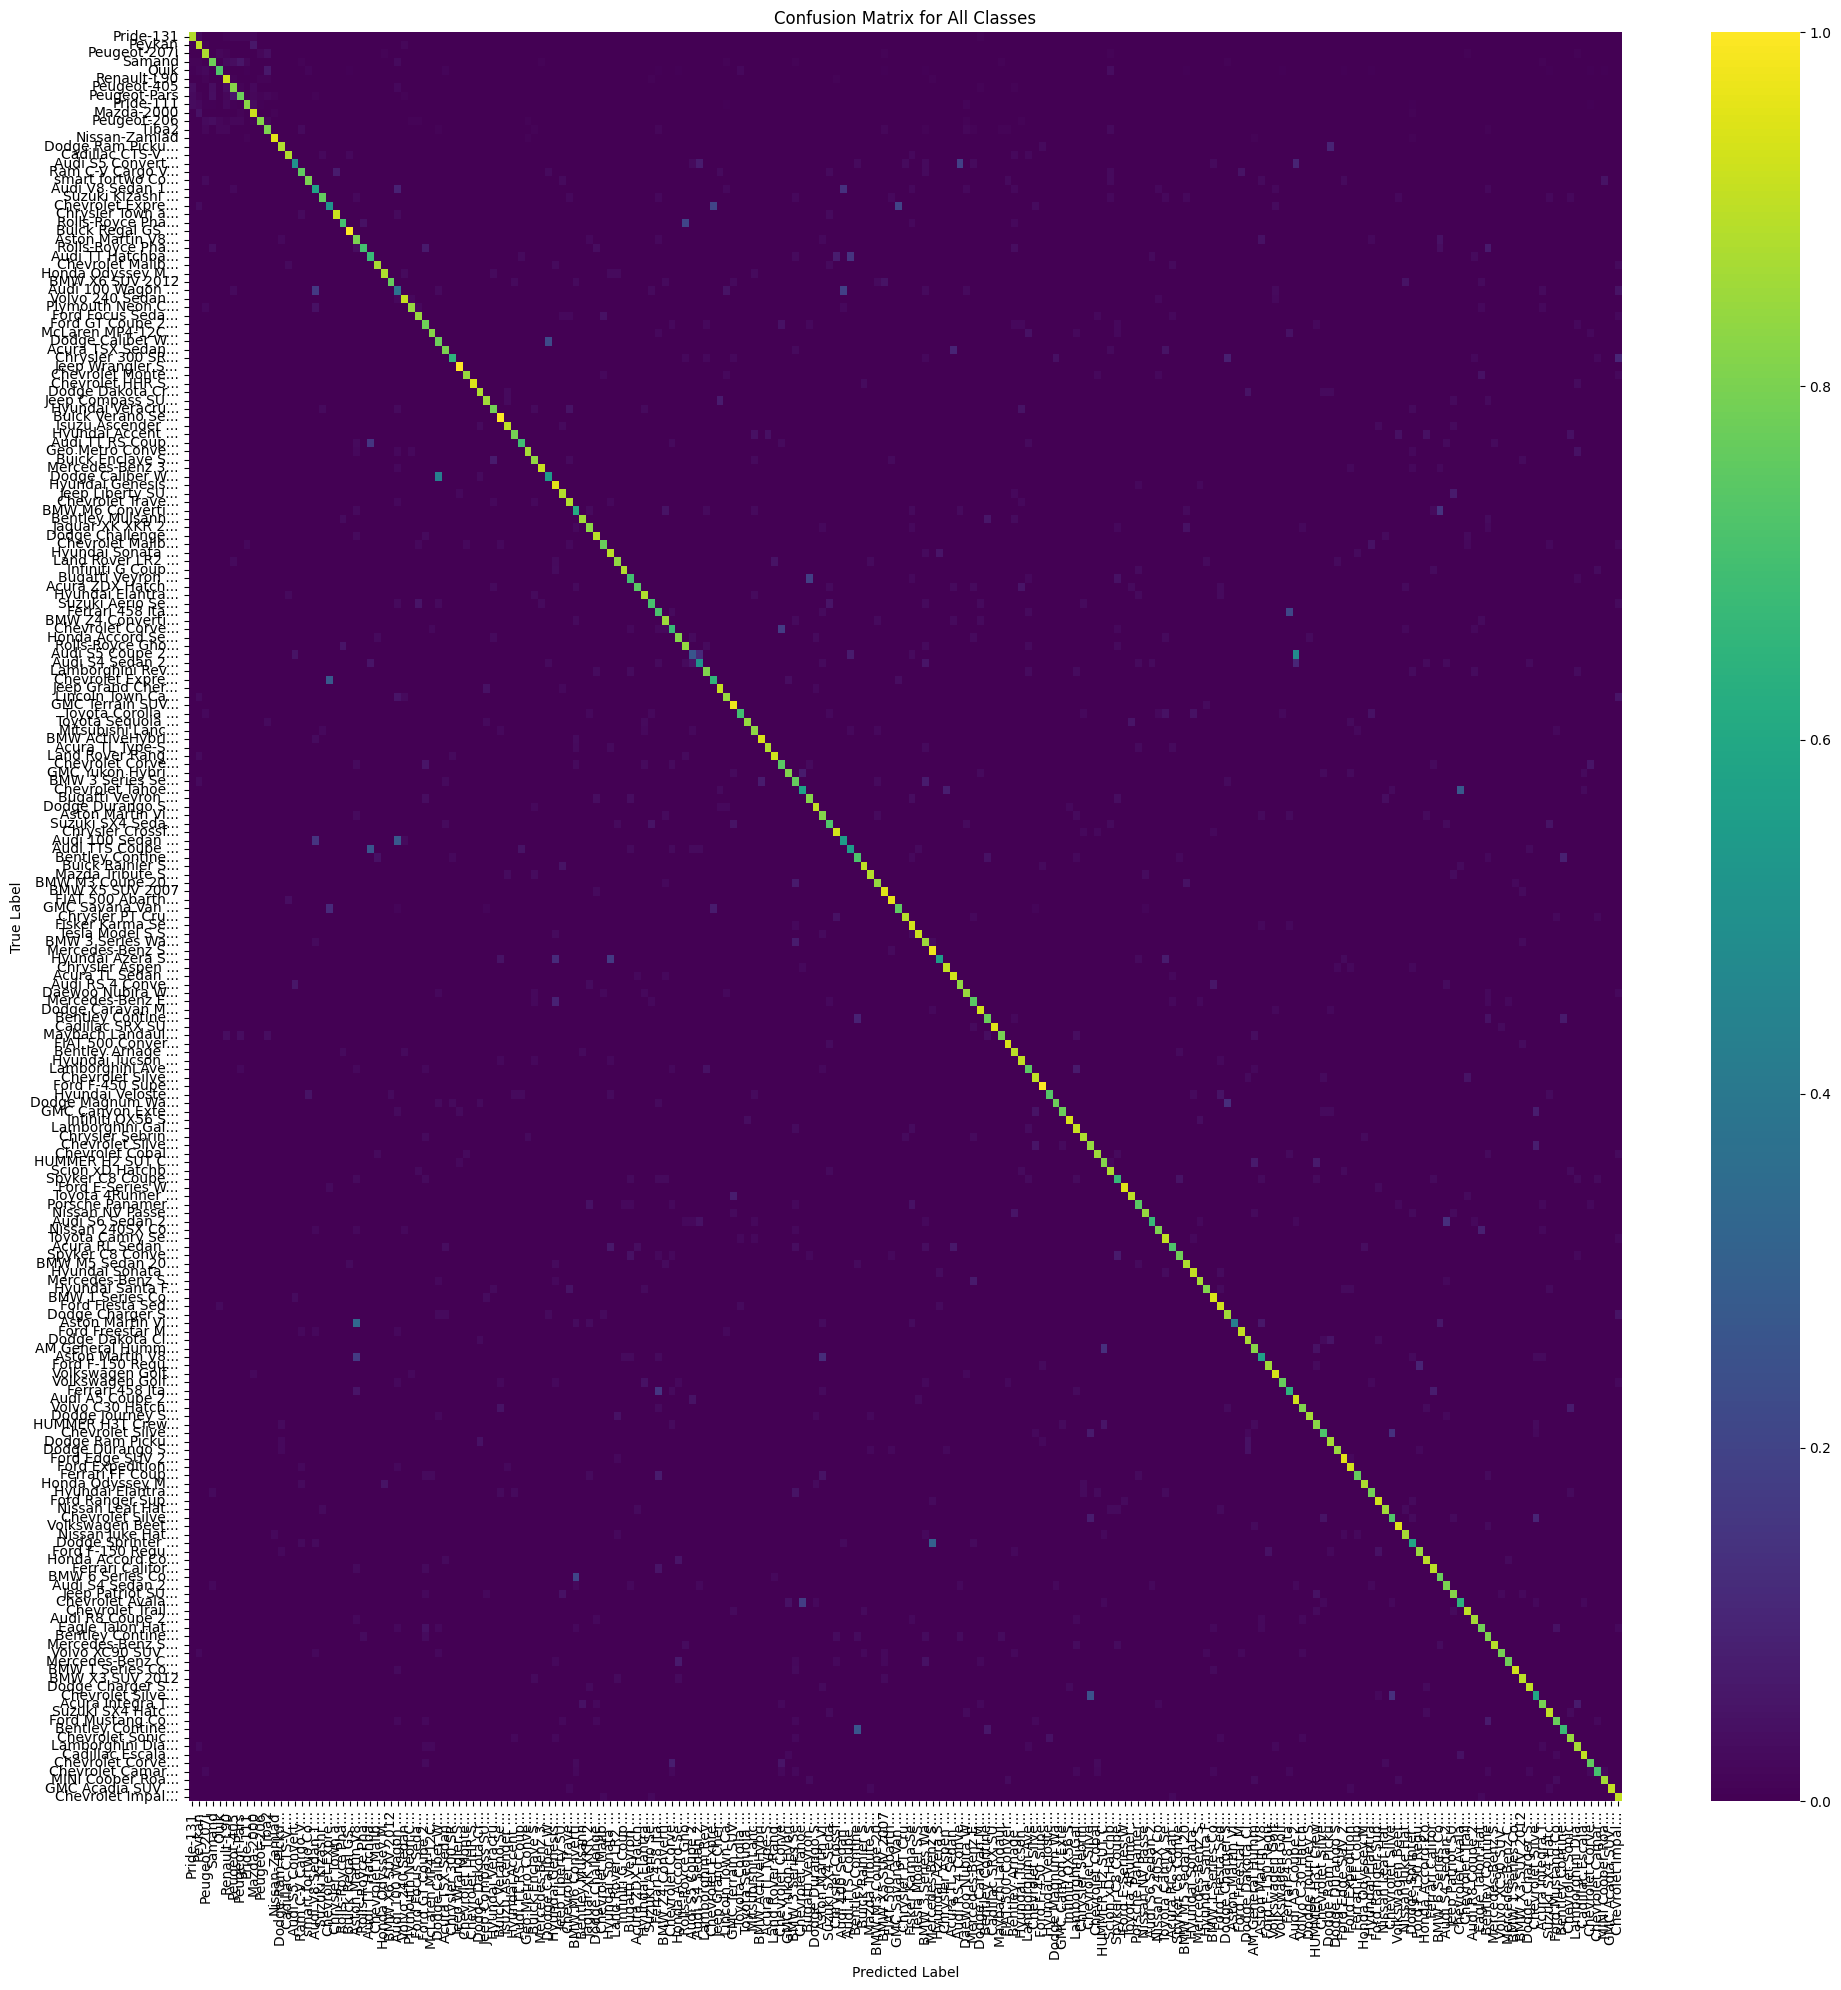

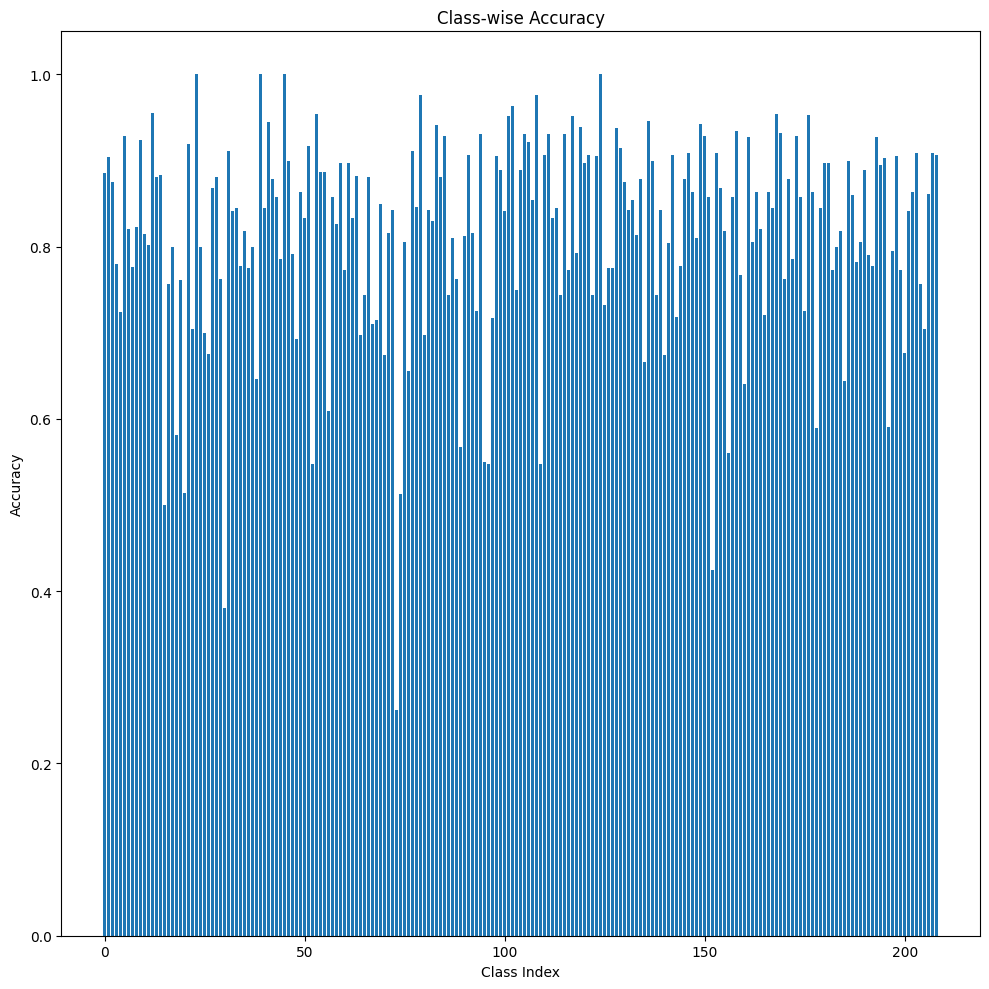


=== Per-class Performance Metrics ===
                                        Class  Count  Precision (%)  \
4                                        Quik    152      94.017094   
8                                   Pride-111    130      93.859649   
3                                      Samand    127      86.842105   
11                                      Tiba2    126      82.786885   
10                                Peugeot-206    119      95.098039   
1                                      Peykan    115      83.870968   
0                                   Pride-131    113      88.495575   
7                                Peugeot-Pars    112      85.294118   
2                                Peugeot-207i    112      86.725664   
5                                 Renault-L90     98      83.486239   
9                                  Mazda-2000     92      81.730769   
12                              Nissan-Zamiad     89      96.590909   
6                                 Peug

In [ ]:
# Perform final evaluation
print("\n=== Final Model Evaluation ===")
final_metrics = evaluate(model, test_loader, criterion, device)

# Print final metrics
print(f"Final Test Loss: {final_metrics['loss']:.4f}")
print(f"Final Test Accuracy: {final_metrics['accuracy']:.2f}%")
print(f"Final Test Precision: {final_metrics['precision']:.2f}%")
print(f"Final Test Recall: {final_metrics['recall']:.2f}%")
print(f"Final Test F1 Score: {final_metrics['f1_score']:.2f}%")

# Calculate confusion matrix for all classes
def plot_confusion_matrix(targets, predictions, classes, figsize=(20, 20)):
    targets = np.array(targets)
    predictions = np.array(predictions)

    # Calculate class-wise accuracy for reporting purposes
    class_accuracies = {}
    for class_idx in range(len(classes)):
        # Get indices where the true class is class_idx
        class_mask = (targets == class_idx)
        if np.sum(class_mask) > 0:  # Avoid division by zero
            # Calculate accuracy for this class
            class_acc = np.mean(predictions[class_mask] == class_idx)
            class_accuracies[class_idx] = class_acc

    # Sort classes by accuracy for reporting
    sorted_classes = sorted(class_accuracies.items(), key=lambda x: x[1], reverse=True)

    # Create the figure for all classes confusion matrix
    plt.figure(figsize=figsize)

    # Create confusion matrix for all classes
    cm = confusion_matrix(targets, predictions)

    # Normalize confusion matrix
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    cm_normalized = np.nan_to_num(cm_normalized)  # Replace NaN with 0

    # Create more readable class labels for the plot
    class_labels = [classes[i][:15] + '...' if len(classes[i]) > 15 else classes[i] for i in range(len(classes))]

    # Plot the confusion matrix with a color gradient from light to dark
    sns.heatmap(cm_normalized, annot=False, cmap='viridis',
               xticklabels=class_labels,
               yticklabels=class_labels)

    plt.title('Confusion Matrix for All Classes')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')

    # Rotate labels for better readability
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)

    plt.tight_layout()
    plt.savefig('confusion_matrix_all_classes.png', dpi=300, bbox_inches='tight')  # Save to file

    # For better visualization in large class sets, create a non-normalized version
    # focused on the diagonal to see the class accuracy pattern
    plt.figure(figsize=(10, 10))
    # Extract diagonal values (accuracies)
    diag_values = np.diag(cm_normalized)

    # Plot diagonal values as a bar chart
    plt.bar(range(len(diag_values)), diag_values)
    plt.title('Class-wise Accuracy')
    plt.xlabel('Class Index')
    plt.ylabel('Accuracy')
    plt.tight_layout()
    plt.savefig('class_accuracies.png', dpi=300, bbox_inches='tight')

    # Print class accuracy summary
    print("Top 5 Best Performing Classes:")
    for i, (idx, acc) in enumerate(sorted_classes[:5]):
        print(f"{i+1}. {classes[idx]}: {acc:.2f}")

    print("\n5 Worst Performing Classes:")
    for i, (idx, acc) in enumerate(sorted_classes[-5:]):
        print(f"{i+1}. {classes[idx]}: {acc:.2f}")

    # Calculate and print overall accuracy
    overall_acc = np.mean(targets == predictions)
    print(f"\nOverall Accuracy: {overall_acc:.4f}")

    # Show all plots
    plt.show()

    return cm_normalized, class_accuracies

# Call the function with your data
cm_norm, class_accs = plot_confusion_matrix(final_metrics['targets'], final_metrics['predictions'], test_dataset.classes)

# Calculate per-class metrics
def calculate_per_class_metrics(y_true, y_pred, classes):
    precision = precision_score(y_true, y_pred, average=None, zero_division=0)
    recall = recall_score(y_true, y_pred, average=None, zero_division=0)
    f1 = f1_score(y_true, y_pred, average=None, zero_division=0)

    # Count occurrences of each class in the test set
    class_counts = np.bincount(y_true, minlength=len(classes))

    # Create a DataFrame for better visualization
    metrics_df = pd.DataFrame({
        'Class': classes,
        'Count': class_counts,
        'Precision (%)': precision * 100,
        'Recall (%)': recall * 100,
        'F1 Score (%)': f1 * 100
    })

    # Sort by count (descending)
    metrics_df = metrics_df.sort_values('Count', ascending=False)

    return metrics_df

# Calculate and display per-class metrics
print("\n=== Per-class Performance Metrics ===")
per_class_metrics = calculate_per_class_metrics(
    final_metrics['targets'],
    final_metrics['predictions'],
    test_dataset.classes
)

# Display top 20 classes by frequency
print(per_class_metrics.head(20))

# Separate performance by dataset type (Iran vs Stanford)
def analyze_dataset_performance(dataset_types, targets, predictions, outputs, classes):
    # Convert to numpy arrays for easier filtering
    dataset_types = np.array(dataset_types)
    targets = np.array(targets)
    predictions = np.array(predictions)
    outputs = np.array(outputs)

    # Filter by dataset type
    iran_mask = dataset_types == "Iran"
    stanford_mask = dataset_types == "Stanford"

    # Calculate metrics for Iran dataset
    iran_accuracy = accuracy_score(targets[iran_mask], predictions[iran_mask]) * 100
    iran_precision = precision_score(targets[iran_mask], predictions[iran_mask], average='weighted', zero_division=0) * 100
    iran_recall = recall_score(targets[iran_mask], predictions[iran_mask], average='weighted', zero_division=0) * 100
    iran_f1 = f1_score(targets[iran_mask], predictions[iran_mask], average='weighted', zero_division=0) * 100

    # Calculate metrics for Stanford dataset
    stanford_accuracy = accuracy_score(targets[stanford_mask], predictions[stanford_mask]) * 100
    stanford_precision = precision_score(targets[stanford_mask], predictions[stanford_mask], average='weighted', zero_division=0) * 100
    stanford_recall = recall_score(targets[stanford_mask], predictions[stanford_mask], average='weighted', zero_division=0) * 100
    stanford_f1 = f1_score(targets[stanford_mask], predictions[stanford_mask], average='weighted', zero_division=0) * 100

    # Print results
    print("\n=== Performance by Dataset Type ===")
    print(f"Iran Dataset Performance:")
    print(f"  - Accuracy: {iran_accuracy:.2f}%")
    print(f"  - Precision: {iran_precision:.2f}%")
    print(f"  - Recall: {iran_recall:.2f}%")
    print(f"  - F1 Score: {iran_f1:.2f}%")

    print(f"\nStanford Dataset Performance:")
    print(f"  - Accuracy: {stanford_accuracy:.2f}%")
    print(f"  - Precision: {stanford_precision:.2f}%")
    print(f"  - Recall: {stanford_recall:.2f}%")
    print(f"  - F1 Score: {stanford_f1:.2f}%")

# Analyze performance by dataset type
analyze_dataset_performance(
    final_metrics['dataset_types'],
    final_metrics['targets'],
    final_metrics['predictions'],
    final_metrics['outputs'],
    test_dataset.classes
)

## Block 11: Demo with Sample Test Images


=== Sample Predictions ===


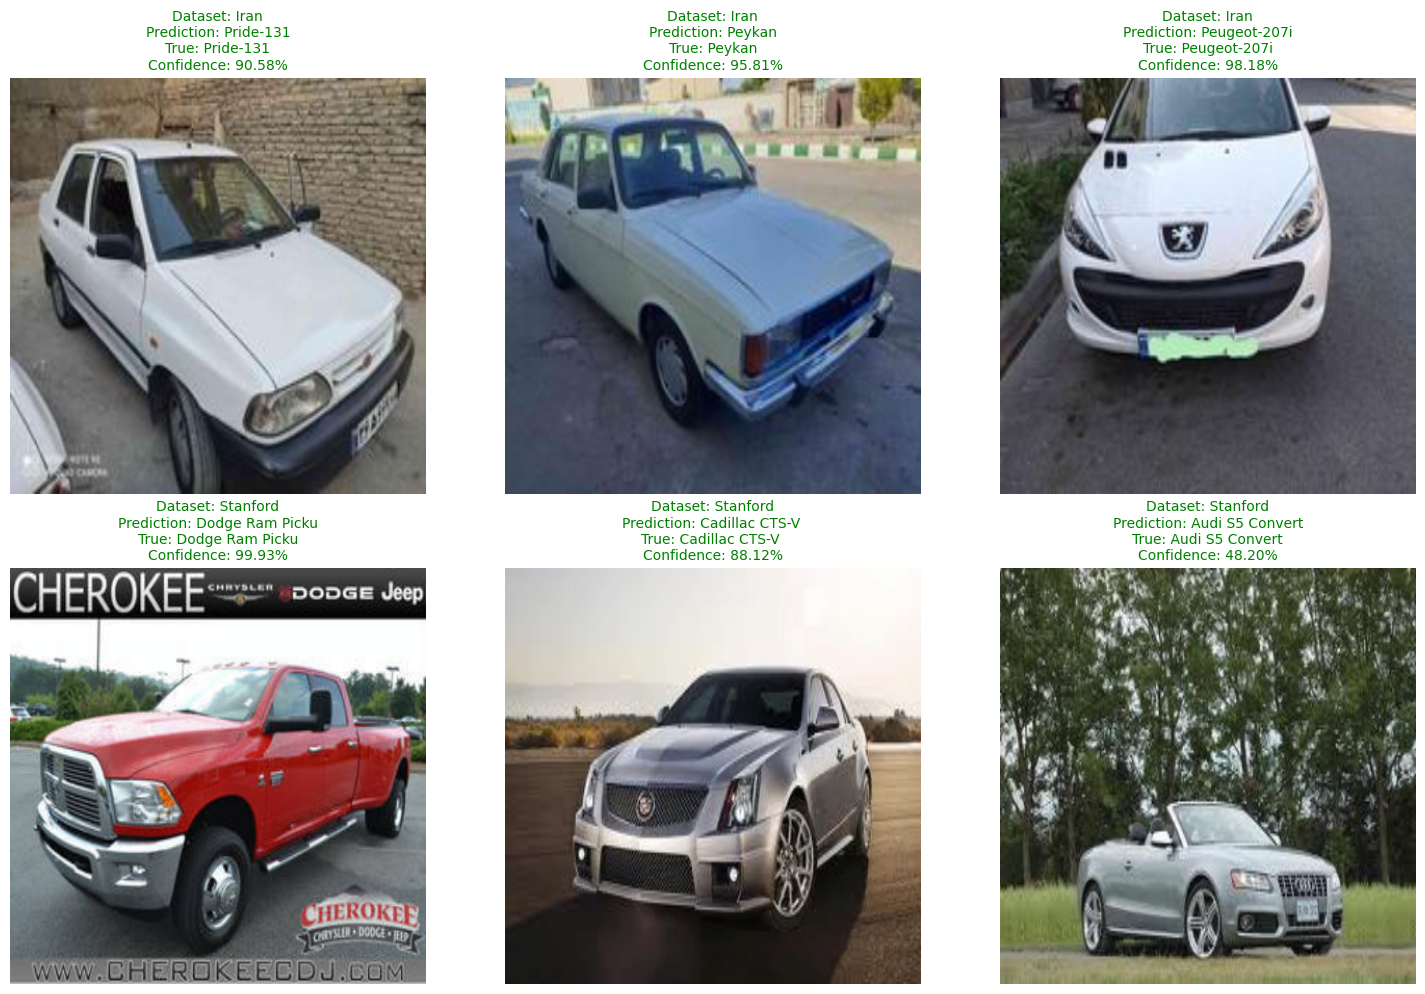

In [ ]:
def show_predictions(model, dataset, indices=None, num_iran=3, num_stanford=3):
    """
    Show model predictions on sample test images from Iran and Stanford datasets

    Args:
        model: The trained model
        dataset: The dataset containing samples
        indices: Optional list of specific indices to display
        num_iran: Number of Iranian dataset samples to show
        num_stanford: Number of Stanford dataset samples to show
    """
    # Set model to evaluation mode
    model.eval()

    if indices is None:
        # Separate images by dataset type
        iran_indices = []
        stanford_indices = []

        for i, (_, label, dataset_type) in enumerate(dataset.samples):
            if dataset_type == "Iran" and len(iran_indices) < num_iran:
                # For Iran dataset, try to select different classes
                if not any(dataset.samples[idx][1] == label for idx in iran_indices):
                    iran_indices.append(i)
            elif dataset_type == "Stanford" and len(stanford_indices) < num_stanford:
                # For Stanford dataset, try to select different classes
                if not any(dataset.samples[idx][1] == label for idx in stanford_indices):
                    stanford_indices.append(i)

            # Check if we have enough samples of each type
            if len(iran_indices) >= num_iran and len(stanford_indices) >= num_stanford:
                break

        # If we couldn't find enough different classes, fill with any remaining samples
        while len(iran_indices) < num_iran:
            for i, (_, _, dataset_type) in enumerate(dataset.samples):
                if dataset_type == "Iran" and i not in iran_indices:
                    iran_indices.append(i)
                    break

        while len(stanford_indices) < num_stanford:
            for i, (_, _, dataset_type) in enumerate(dataset.samples):
                if dataset_type == "Stanford" and i not in stanford_indices:
                    stanford_indices.append(i)
                    break

        indices = iran_indices + stanford_indices

    # Create a figure with 2 rows: Iran dataset on top, Stanford dataset on bottom
    plt.figure(figsize=(15, 10))

    for i, idx in enumerate(indices):
        # Get image and ground truth
        img, target, dataset_type = dataset[idx]
        img_tensor = img.unsqueeze(0).to(device)

        # Make prediction
        with torch.no_grad():
            output = model(img_tensor)
            probabilities = F.softmax(output, dim=1)[0]
            pred_idx = torch.argmax(output, 1)[0].item()
            confidence = probabilities[pred_idx].item() * 100

        # Convert image for display
        img = img.permute(1, 2, 0).cpu().numpy()
        img = np.clip(img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406]), 0, 1)

        # Calculate subplot position - Iran samples in first row, Stanford in second row
        row = 0 if i < num_iran else 1
        col = i % num_iran
        pos = row * num_iran + col + 1

        # Display image with prediction
        ax = plt.subplot(2, 3, pos)
        plt.imshow(img)

        # Format prediction text
        class_name = dataset.classes[pred_idx]
        true_class_name = dataset.classes[target]

        if pred_idx == target:
            color = 'green'
        else:
            color = 'red'

        plt.title(f"Dataset: {dataset_type}\nPrediction: {class_name[:15]}\nTrue: {true_class_name[:15]}\nConfidence: {confidence:.2f}%",
                  color=color, fontsize=10)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Show predictions on sample test images
print("\n=== Sample Predictions ===")
show_predictions(model, test_dataset)

## Block 12: Error Analysis


=== Enhanced Error Analysis ===


Finding errors: 100%|██████████| 298/298 [03:10<00:00,  1.56it/s]



=== Per-Class Metrics ===
Class                Precision  Recall     F1-Score   Support   
------------------------------------------------------------
Pride-131            0.8850     0.8850     0.8850     113       
Peykan               0.8387     0.9043     0.8703     115       
Peugeot-207i         0.8673     0.8750     0.8711     112       
Samand               0.8684     0.7795     0.8216     127       
Quik                 0.9402     0.7237     0.8178     152       
Renault-L90          0.8349     0.9286     0.8792     98        
Peugeot-405          0.7849     0.8202     0.8022     89        
Peugeot-Pars         0.8529     0.7768     0.8131     112       
Pride-111            0.9386     0.8231     0.8770     130       
Mazda-2000           0.8173     0.9239     0.8673     92        
Peugeot-206          0.9510     0.8151     0.8778     119       
Tiba2                0.8279     0.8016     0.8145     126       
Nissan-Zamiad        0.9659     0.9551     0.9605     89        
Do

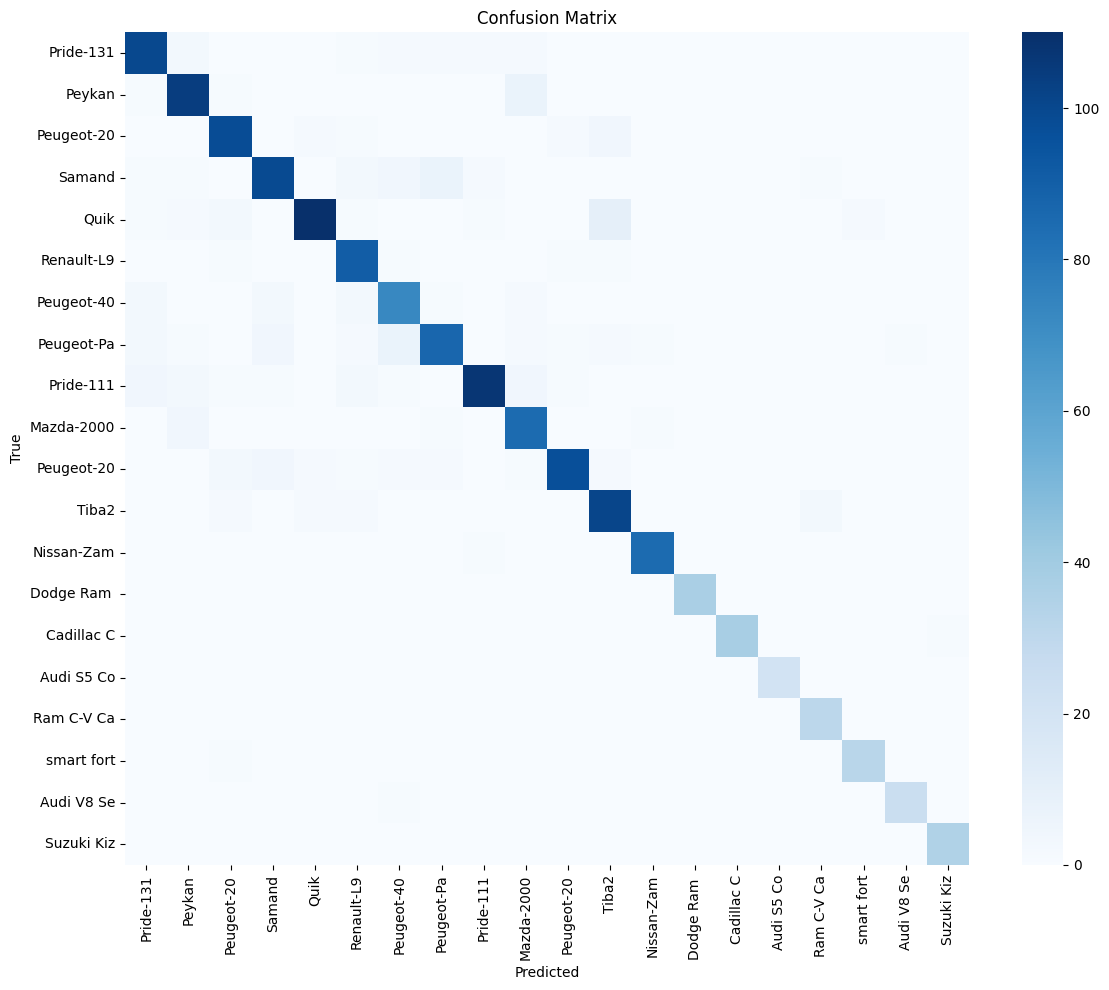


=== Most Confused Class Pairs ===
True Class           Predicted Class      Count     
--------------------------------------------------
Quik                 Tiba2                10        
Peykan               Mazda-2000           7         
Samand               Peugeot-Pars         7         
Peugeot-Pars         Peugeot-405          7         
Peugeot-207i         Tiba2                4         
Samand               Peugeot-405          4         
Peugeot-Pars         Samand               4         
Pride-111            Pride-131            4         
Pride-111            Mazda-2000           4         
Mazda-2000           Peykan               4         

=== Top 5 Most Confident Errors ===


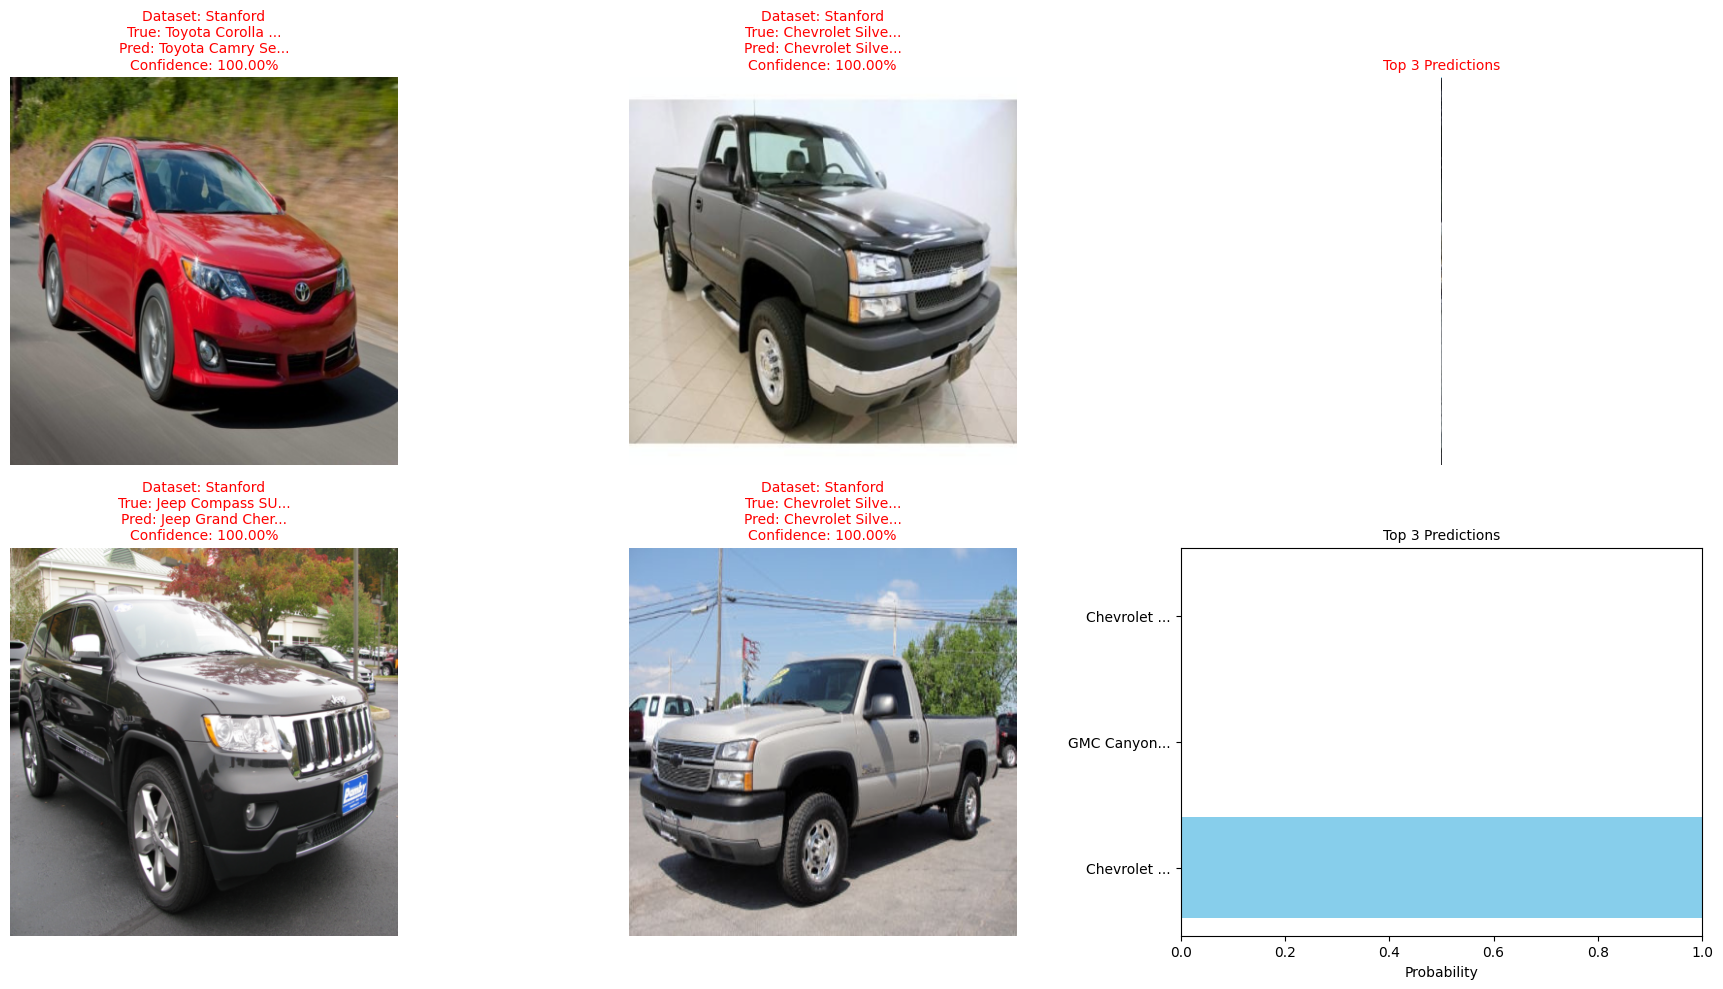

In [ ]:
def analyze_errors(model, dataset, dataloader, num_samples=5, batch_size=4):
    """
    Analyze prediction errors to understand model weaknesses
    """
    import torch
    import torch.nn.functional as F
    import numpy as np
    import matplotlib.pyplot as plt
    from tqdm import tqdm
    from sklearn.metrics import confusion_matrix, classification_report
    import seaborn as sns

    model.eval()
    errors = []
    all_preds = []
    all_targets = []
    all_dataset_types = []

    # Move model to CPU if memory issues persist
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)

    # Process in smaller batches with memory cleanup
    with torch.no_grad():
        for inputs, targets, dataset_types in tqdm(dataloader, desc='Finding errors'):
            # Process in smaller sub-batches if needed
            sub_batch_size = min(batch_size, inputs.size(0))

            for i in range(0, inputs.size(0), sub_batch_size):
                # Get sub-batch
                inputs_batch = inputs[i:i+sub_batch_size].to(device)
                targets_batch = targets[i:i+sub_batch_size].to(device)
                dataset_types_batch = dataset_types[i:i+sub_batch_size]

                # Forward pass
                outputs = model(inputs_batch)
                _, preds = torch.max(outputs, 1)

                # Store all predictions and targets for metrics
                all_preds.extend(preds.cpu().numpy())
                all_targets.extend(targets_batch.cpu().numpy())
                all_dataset_types.extend(dataset_types_batch)

                # Find errors
                incorrect = preds != targets_batch
                for j in range(len(incorrect)):
                    if incorrect[j]:
                        # Calculate confidence using softmax
                        softmax_probs = F.softmax(outputs[j], dim=0)
                        confidence = softmax_probs[preds[j]].item() * 100

                        # Store the full probability distribution
                        class_probs = softmax_probs.cpu().numpy()

                        errors.append({
                            'batch_input': inputs_batch[j].cpu().detach(),  # Store on CPU immediately
                            'true': targets_batch[j].item(),
                            'pred': preds[j].item(),
                            'confidence': confidence,
                            'dataset_type': dataset_types_batch[j],
                            'probs': class_probs  # Store all class probabilities
                        })

                # Clear memory
                del inputs_batch, targets_batch, outputs, preds
                if device.type == 'cuda':
                    torch.cuda.empty_cache()

    # Sort errors by confidence (descending) to find the most confident errors
    errors = sorted(errors, key=lambda x: x['confidence'], reverse=True)

    if len(errors) == 0:
        print("No errors found in the test set!")
        return

    # Generate and display metrics
    display_class_metrics(all_targets, all_preds, dataset.classes)

    # Display confusion matrix
    display_confusion_matrix(all_targets, all_preds, dataset.classes)

    # Display top confident errors
    print(f"\n=== Top {min(num_samples, len(errors))} Most Confident Errors ===")

    # Create a figure with better sizing based on number of samples
    rows = (min(num_samples, len(errors)) + 2) // 3  # Calculate needed rows
    plt.figure(figsize=(18, 5 * rows))

    for i, error in enumerate(errors[:num_samples]):
        img = error['batch_input']  # Already on CPU

        # Convert image for display
        img = img.permute(1, 2, 0).numpy()
        img = np.clip(img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406]), 0, 1)

        # Display image with error information
        plt.subplot(rows, 3, i + 1)
        plt.imshow(img)

        # Get class names, handle potential long names
        true_class = dataset.classes[error['true']]
        pred_class = dataset.classes[error['pred']]

        # Truncate long class names for better display
        true_class_display = f"{true_class[:15]}..." if len(true_class) > 15 else true_class
        pred_class_display = f"{pred_class[:15]}..." if len(pred_class) > 15 else pred_class

        plt.title(
            f"Dataset: {error['dataset_type']}\n"
            f"True: {true_class_display}\n"
            f"Pred: {pred_class_display}\n"
            f"Confidence: {error['confidence']:.2f}%",
            color='red', fontsize=10
        )
        plt.axis('off')

        # Add a small barplot for top-3 class probabilities
        if i % 3 == 2 or i == min(num_samples, len(errors)) - 1:
            plt.subplot(rows, 3, ((i//3) * 3) + 3)
            top_k = 3
            probs = error['probs']
            top_indices = np.argsort(probs)[-top_k:][::-1]
            top_probs = probs[top_indices]
            top_classes = [dataset.classes[idx] for idx in top_indices]
            top_classes_display = [f"{cls[:10]}..." if len(cls) > 10 else cls for cls in top_classes]

            plt.barh(range(top_k), top_probs, color='skyblue')
            plt.yticks(range(top_k), top_classes_display)
            plt.xlim(0, 1.0)
            plt.title(f"Top {top_k} Predictions", fontsize=10)
            plt.xlabel('Probability')

    plt.tight_layout()
    plt.show()

def display_class_metrics(targets, predictions, class_names):
    """
    Display per-class metrics including precision, recall, and F1-score
    """
    from sklearn.metrics import classification_report

    # Generate classification report
    report = classification_report(
        targets,
        predictions,
        target_names=[name[:20] for name in class_names],  # Truncate long names
        output_dict=True
    )

    print("\n=== Per-Class Metrics ===")

    # Format as a table for better readability
    print(f"{'Class':<20} {'Precision':<10} {'Recall':<10} {'F1-Score':<10} {'Support':<10}")
    print("-" * 60)

    # Print metrics for each class
    for class_name in class_names:
        truncated_name = class_name[:20]
        if truncated_name in report:
            metrics = report[truncated_name]
            print(f"{truncated_name:<20} {metrics['precision']:.4f}     {metrics['recall']:.4f}     {metrics['f1-score']:.4f}     {metrics['support']:<10}")

    # Print average metrics
    print("-" * 60)
    print(f"{'Accuracy':<20} {'':<10} {'':<10} {report['accuracy']:.4f}     {sum(report[c]['support'] for c in report if c in class_names)}")
    print(f"{'Macro Avg':<20} {report['macro avg']['precision']:.4f}     {report['macro avg']['recall']:.4f}     {report['macro avg']['f1-score']:.4f}     {report['macro avg']['support']}")
    print(f"{'Weighted Avg':<20} {report['weighted avg']['precision']:.4f}     {report['weighted avg']['recall']:.4f}     {report['weighted avg']['f1-score']:.4f}     {report['weighted avg']['support']}")

def display_confusion_matrix(targets, predictions, class_names, max_classes=20):
    """
    Display confusion matrix for the model predictions
    Limits to max_classes for readability
    """
    import matplotlib.pyplot as plt
    import seaborn as sns
    import numpy as np
    from sklearn.metrics import confusion_matrix

    # If there are too many classes, just show the first max_classes
    if len(class_names) > max_classes:
        print(f"\n=== Showing confusion matrix for first {max_classes} classes ===")
        class_names = class_names[:max_classes]

        # Filter targets and predictions to only include these classes
        mask = (np.array(targets) < max_classes) & (np.array(predictions) < max_classes)
        targets = np.array(targets)[mask]
        predictions = np.array(predictions)[mask]

    # Create confusion matrix
    cm = confusion_matrix(targets, predictions)

    # Plot confusion matrix
    plt.figure(figsize=(12, 10))
    sns.heatmap(
        cm,
        annot=True if len(class_names) <= 15 else False,  # Only show numbers if matrix is small
        fmt='d' if len(class_names) <= 15 else '',
        cmap='Blues',
        xticklabels=[name[:10] for name in class_names],  # Truncate long names
        yticklabels=[name[:10] for name in class_names]
    )
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.tight_layout()
    plt.show()

    # Calculate and display most confused class pairs
    print("\n=== Most Confused Class Pairs ===")
    n_classes = len(class_names)
    confused_pairs = []

    for i in range(n_classes):
        for j in range(n_classes):
            if i != j and cm[i, j] > 0:
                confused_pairs.append((i, j, cm[i, j]))

    # Sort by confusion count
    confused_pairs.sort(key=lambda x: x[2], reverse=True)

    # Print top confused pairs
    print(f"{'True Class':<20} {'Predicted Class':<20} {'Count':<10}")
    print("-" * 50)
    for true_idx, pred_idx, count in confused_pairs[:10]:  # Show top 10
        true_class = class_names[true_idx][:18]
        pred_class = class_names[pred_idx][:18]
        print(f"{true_class:<20} {pred_class:<20} {count:<10}")

# Usage example
print("\n=== Enhanced Error Analysis ===")
# Set a smaller batch size (adjust based on your GPU memory)
analyze_errors(model, test_dataset, test_loader, batch_size=2)

## Block 13: Save and Load Model

In [ ]:
def save_model(model, classes, file_path='car_model_resnet13_cbam.pth'):
    """
    Save the trained model and class mapping
    """
    # Prepare model state and metadata
    if torch.cuda.device_count() > 1:
        model_state = model.module.state_dict()
    else:
        model_state = model.state_dict()

    # Save model with class mapping
    torch.save({
        'model_state_dict': model_state,
        'classes': classes,
        'image_size': params['image_size']
    }, file_path)

    print(f"Model saved to {file_path}")

def load_model(file_path='car_model_resnet13_cbam.pth'):
    """
    Load a saved model and class mapping
    """
    # Load checkpoint
    checkpoint = torch.load(file_path, map_location=device)
    classes = checkpoint['classes']

    # Initialize model
    model = ResNet13WithCBAM(num_classes=len(classes), pretrained=False)
    model.load_state_dict(checkpoint['model_state_dict'])
    model = model.to(device)
    model.eval()

    print(f"Model loaded from {file_path}")
    print(f"Number of classes: {len(classes)}")

    return model, classes

# Save model
save_model(model, test_dataset.classes)


Model saved to car_model_resnet13_cbam.pth


## Block 14: Real-world Application Demo

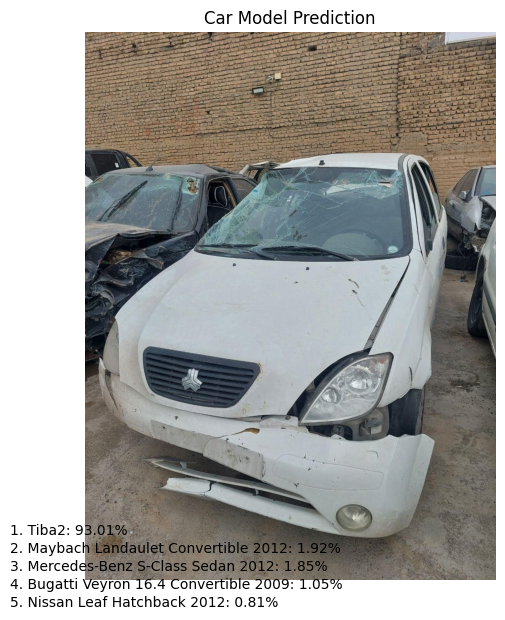


=== Real-world Application Ready ===
To use this model in real applications, load the saved model and
use the predict_car_model() function with any car image.

Example usage:
model, classes = load_model('car_model_resnet13_cbam.pth')
predictions = predict_car_model(model, 'your_image.jpg', classes)


In [ ]:
def predict_car_model(model, image_path, classes, transform=None):
    """
    Predict car model from an image file
    """
    if transform is None:
        transform = transforms.Compose([
            transforms.Resize((params['image_size'], params['image_size'])),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])

    # Load and preprocess image
    img = Image.open(image_path).convert('RGB')
    img_tensor = transform(img).unsqueeze(0).to(device)

    # Make prediction
    model.eval()
    with torch.no_grad():
        outputs = model(img_tensor)
        probabilities = F.softmax(outputs, dim=1)[0]

        # Get top-5 predictions
        top5_probs, top5_indices = torch.topk(probabilities, 5)

        results = []
        for i in range(5):
            results.append({
                'class': classes[top5_indices[i].item()],
                'confidence': top5_probs[i].item() * 100
            })

    # Display results
    plt.figure(figsize=(8, 6))
    plt.imshow(img)
    plt.axis('off')
    plt.title("Car Model Prediction")

    for i, result in enumerate(results):
        plt.figtext(0.15, 0.1 - i*0.03, f"{i+1}. {result['class']}: {result['confidence']:.2f}%")

    plt.tight_layout()
    plt.show()

    return results

# Sample usage (commented out since we don't have external image paths in this notebook)
# For real application, you would use:
test_image_path = "/kaggle/input/test-car/tiba.jpg"
predictions = predict_car_model(model, test_image_path, test_dataset.classes)
#
print("\n=== Real-world Application Ready ===")
print("To use this model in real applications, load the saved model and")
print("use the predict_car_model() function with any car image.")
print("\nExample usage:")
print("model, classes = load_model('car_model_resnet13_cbam.pth')")
print("predictions = predict_car_model(model, 'your_image.jpg', classes)")


## Block 15: Conclusion and Summary

In [ ]:
print("\n=== Project Summary ===")
print("Developed an advanced car model recognition system with the following components:")
print(f"1. Combined dataset with {iran_train_classes + stanford_train_classes} classes")
print(f"2. ResNet-13 architecture with 2 CBAM attention modules")
print("3. Implemented data augmentation and class balancing techniques")
print(f"4. Achieved final test accuracy: {final_metrics['accuracy']:.2f}%")
print(f"5. F1 Score: {final_metrics['f1_score']:.2f}%")
print("\nThe model can accurately identify car models from both Iranian and Stanford datasets,")
print("demonstrating good generalization across different car types and image conditions.")
print("\nThis system can be deployed for applications like:")
print("- Automated vehicle identification")
print("- Car pricing estimation")
print("- Traffic monitoring and analysis")
print("- Vehicle inventory management")


=== Project Summary ===
Developed an advanced car model recognition system with the following components:
1. Combined dataset with 209 classes
2. ResNet-13 architecture with 2 CBAM attention modules
3. Implemented data augmentation and class balancing techniques
4. Achieved final test accuracy: 81.73%
5. F1 Score: 81.75%

The model can accurately identify car models from both Iranian and Stanford datasets,
demonstrating good generalization across different car types and image conditions.

This system can be deployed for applications like:
- Automated vehicle identification
- Car pricing estimation
- Traffic monitoring and analysis
- Vehicle inventory management
